# Air Quality Forecasting

## Libraries and Data Loading

In [140]:
#Loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from windrose import WindroseAxes
from sklearn.decomposition import PCA
from scipy.stats import uniform, loguniform
from sklearn.svm import SVR
from darts.dataprocessing.transformers import Scaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler
from darts import TimeSeries
from darts.models import LightGBMModel, CatBoostModel
from darts.metrics import mae, rmse, mape
from sklearn.cluster import KMeans
from darts.models import NaiveSeasonal, ExponentialSmoothing, AutoARIMA
import logging
import warnings

In [2]:
#Loading datasets
pm10 = pd.read_csv('../data/2023_PM10_24g.csv')
pm25 = pd.read_csv('../data/2023_PM25_24g.csv')
nox = pd.read_csv('../data/2023_NOx_1g.csv')
co = pd.read_csv('../data/2023_CO_1g.csv')
o3 = pd.read_csv('../data/2023_O3_1g.csv')
stations_metadata = pd.read_csv(
    '../data/stations_metadata.csv',
    sep=';'
)
stations_metadata2 = pd.read_csv(
    '../data/stations_metadata2.csv',
    sep=';'
)

## Data Preprocessing

In [3]:
pm25.head(3)

,Time,DsLegPolarna-PM2.5-24g,DsOsieczow21-PM2.5-24g,DsWalbrzWyso-PM2.5-24g,DsWrocNaGrob-PM2.5-24g,DsZgorBohGet-PM2.5-24g,KpBydFieldor-PM2.5-24g,KpGrudSienki-PM2.5-24g,KpToruDziewu-PM2.5-24g,KpWloclGniaz-PM2.5-24g,...,WmOlsPuszkin-PM2.5-24g,WmOstrPilsud-PM2.5-24g,WmPuszczaBor-PM2.5-24g,WpKaliSawick-PM2.5-24g,WpPleszAlMic-PM2.5-24g,WpPoznSzwajc-PM2.5-24g,ZpKoszSpasow-PM2.5-24g,ZpMyslZaBram-PM2.5-24g,ZpSzczAndrze-PM2.5-24g,ZpSzczec1Maj-PM2.5-24g
0,2023-01-01T00:00:00,13.6,9.8,12.1,15.0,15.5,4.4,12.6,9.7,12.7,...,12.31,9.86,9.69,11.9,12.2,14.2,11.1,45.0,14.1,8.3
1,2023-01-02T00:00:00,15.3,10.3,12.6,14.6,13.6,12.4,20.3,14.1,16.2,...,13.89,14.34,12.32,16.1,NaN,14.2,7.4,6.7,6.7,8.2
2,2023-01-03T00:00:00,20.0,11.5,26.1,13.6,11.7,5.2,10.7,5.6,7.3,...,3.27,4.97,3.90,15.5,NaN,9.7,4.7,13.2,4.0,4.2


In [4]:
print(f"Number of measurements (PM25) in particular areas: {len(pm25)}")
pm25.isna().sum()

Number of measurements (PM25) in particular areas: 365


Time                        0
DsLegPolarna-PM2.5-24g     12
DsOsieczow21-PM2.5-24g      6
DsWalbrzWyso-PM2.5-24g      6
DsWrocNaGrob-PM2.5-24g      4
DsZgorBohGet-PM2.5-24g     10
KpBydFieldor-PM2.5-24g     13
KpGrudSienki-PM2.5-24g      0
KpToruDziewu-PM2.5-24g      3
KpWloclGniaz-PM2.5-24g     13
KpZielBoryTu-PM2.5-24g      0
LbBiaPodOrze-PM2.5-24g      5
LbChelmPolan-PM2.5-24g      4
LbLubSliwins-PM2.5-24g     15
LdLodzCzerni-PM2.5-24g      4
LdLodzLegion-PM2.5-24g      1
LdPioTrKraPr-PM2.5-24g      2
LuGorzPilsud-PM2.5-24g     14
LuNowaSolKos-PM2.5-24g    152
LuZielKrotka-PM2.5-24g      0
MpBochKonfed-PM2.5-24g      1
MpKrakBujaka-PM2.5-24g      6
MpNoSaczNadb-PM2.5-24g     13
MpTarBitStud-PM2.5-24g     20
MpTrzebOsZWM-PM2.5-24g      1
MpZakopaSien-PM2.5-24g      5
MzPlocKroJad-PM2.5-24g     21
MzRadHallera-PM2.5-24g     11
MzWarTolstoj-PM2.5-24g     41
MzWarWokalna-PM2.5-24g      8
OpKluczMicki-PM2.5-24g      8
OpOpoleOsAKr-PM2.5-24g      4
PdBialWarsza-PM2.5-24g     14
PdLomSikor

In [5]:
pm10.head(3)

,Time,DsGlogWiStwo-PM10-24g,DsJelGorSoko-PM10-24g,DsLegAlRzecz-PM10-24g,DsLwowekSlasMOB-PM10-24g,DsNowRudJezi-PM10-24g,DsOlawZolnAK-PM10-24g,DsOlesBrzozo-PM10-24g,DsOsieczow21-PM10-24g,DsPolanZdrojMOB-PM10-24g,...,WpPoznSzyman-PM10-24g,WpWagrowLipo-PM10-24g,ZpKolZolkiew-PM10-24g,ZpKoszChopin-PM10-24g,ZpMyslZaBram-PM10-24g,ZpSwinMatejkMOB-PM10-24g,ZpSzczAndrze-PM10-24g,ZpSzczec1Maj-PM10-24g,ZpSzczecPrze-PM10-24g,ZpSzczPilsud-PM10-24g
0,2023-01-01T00:00:00,17.5,15.3,19.4,23.3,70.5,13.7,17.5,14.0,NaN,...,18.76,19.68,15.3,22.7,NaN,15.8,18.0,15.1,20.0,16.9
1,2023-01-02T00:00:00,31.1,12.8,24.2,28.2,108.1,16.8,24.4,14.6,NaN,...,19.80,25.27,11.3,12.2,NaN,9.6,11.4,16.1,17.6,14.5
2,2023-01-03T00:00:00,20.6,12.1,33.0,39.1,60.1,21.6,21.8,14.7,NaN,...,13.64,20.20,12.6,12.2,14.9,10.9,9.4,10.7,14.0,16.0


In [6]:
print(f"Number of measurements (PM10) in particular areas: {len(pm10)}")
pm10.isna().sum()

Number of measurements (PM10) in particular areas: 365


Time                         0
DsGlogWiStwo-PM10-24g       29
DsJelGorSoko-PM10-24g       12
DsLegAlRzecz-PM10-24g       10
DsLwowekSlasMOB-PM10-24g     0
                            ..
ZpSwinMatejkMOB-PM10-24g    26
ZpSzczAndrze-PM10-24g        0
ZpSzczec1Maj-PM10-24g        5
ZpSzczecPrze-PM10-24g        1
ZpSzczPilsud-PM10-24g        0
Length: 180, dtype: int64

In [7]:
nox.head(3)

,Time,DsCzerStraza-NOx-1g,DsJelGorOgin-NOx-1g,DsKlodzSzkol-NOx-1g,DsLegAlRzecz-NOx-1g,DsOlawZolnAK-NOx-1g,DsOsieczow21-NOx-1g,DsStrzegomMOB-NOx-1g,DsTrzebniMaj-NOx-1g,DsWalbrzWyso-NOx-1g,...,WpPoznDabrow-NOx-1g,WpPoznSzwajc-NOx-1g,WpSzamotKollMOB-NOx-1g,ZpKoszArKraj-NOx-1g,ZpKoszChopin-NOx-1g,ZpSwinMatejkMOB-NOx-1g,ZpSzczAndrze-NOx-1g,ZpSzczecPrze-NOx-1g,ZpSzczPilsud-NOx-1g,ZpWiduBulRyb-NOx-1g
0,2023-01-01T00:00:00,3.20859,3.44873,5.95110,9.77776,3.21654,4.25216,NaN,10.6171,4.40132,...,24.3382,5.14447,3.32582,NaN,6.98834,NaN,6.54223,3.02417,11.8756,5.18736
1,2023-01-01T01:00:00,2.09576,4.83068,6.27220,13.81740,4.07969,4.35466,NaN,11.3887,4.44806,...,29.1591,4.97757,4.40238,NaN,21.78860,7.52584,23.00610,6.00418,17.8565,5.58198
2,2023-01-01T02:00:00,1.62573,3.42324,4.26672,4.50064,3.13131,5.34625,NaN,10.9351,5.65315,...,25.7833,5.73524,2.35229,NaN,5.80501,3.28652,4.21171,3.08318,11.2472,5.64093


In [8]:
print(f"Number of measurements (NOx) in particular areas: {len(nox)}")
nox.isna().sum()

Number of measurements (NOx) in particular areas: 8761


Time                        0
DsCzerStraza-NOx-1g       123
DsJelGorOgin-NOx-1g       188
DsKlodzSzkol-NOx-1g       168
DsLegAlRzecz-NOx-1g       139
                         ... 
ZpSwinMatejkMOB-NOx-1g    287
ZpSzczAndrze-NOx-1g       119
ZpSzczecPrze-NOx-1g       234
ZpSzczPilsud-NOx-1g       129
ZpWiduBulRyb-NOx-1g       199
Length: 142, dtype: int64

In [9]:
co.head(3)

,Time,DsJelGorOgin-CO-1g,DsLegAlRzecz-CO-1g,DsWalbrzWyso-CO-1g,DsWrocAlWisn-CO-1g,DsWrocWybCon-CO-1g,KpBydPlPozna-CO-1g,KpGrudPilsud-CO-1g,KpNaklWawrzy-CO-1g,KpToruKaszow-CO-1g,...,WmElbBazynsk-CO-1g,WmOlsPuszkin-CO-1g,WmOstrPilsud-CO-1g,WpKaliSawick-CO-1g,WpKozieosLes-CO-1g,WpPilaKusoci-CO-1g,WpPoznDabrow-CO-1g,WpPoznSzwajc-CO-1g,ZpSzczecPrze-CO-1g,ZpSzczPilsud-CO-1g
0,2023-01-01T00:00:00,0.240851,0.396295,0.351980,0.374706,0.336582,0.228,0.361,NaN,0.283,...,0.309856,0.248936,0.368558,0.33271,0.32302,0.36225,0.23169,0.32127,0.14347,0.15509
1,2023-01-01T01:00:00,0.230979,0.383071,0.354536,0.462186,0.358403,0.237,0.340,NaN,0.257,...,0.403298,0.259337,0.344526,0.27508,0.33913,0.35174,0.23496,0.32176,0.13793,0.15981
2,2023-01-01T02:00:00,0.230611,0.328570,0.361657,0.441261,0.318712,0.257,0.343,NaN,0.347,...,0.393793,0.231591,0.340462,0.22126,0.32542,0.34605,0.22526,0.32205,0.12904,0.14422


In [10]:
print(f"Number of measurements (CO) in particular areas: {len(co)}")
co.isna().sum()

Number of measurements (CO) in particular areas: 8761


Time                        0
DsJelGorOgin-CO-1g        241
DsLegAlRzecz-CO-1g        144
DsWalbrzWyso-CO-1g         41
DsWrocAlWisn-CO-1g         42
DsWrocWybCon-CO-1g         53
KpBydPlPozna-CO-1g         11
KpGrudPilsud-CO-1g        370
KpNaklWawrzy-CO-1g        185
KpToruKaszow-CO-1g        226
KpWloclOkrze-CO-1g         66
KpZielBoryTu-CO-1g        209
LbLubObywate-CO-1g        409
LbZamoHrubie-CO-1g        226
LdLodzJanPaw-CO-1g         37
LdPioTrKraPr-CO-1g        126
LdRadomsRoln-CO-1g          6
LdZgieMielcz-CO-1g        183
LuGorzKosGdy-CO-1g       1454
LuWsKaziWiel-CO-1g        122
LuZarySzyman-CO-1g        219
LuZielKrotka-CO-1g        354
MpKrakAlKras-CO-1g        170
MpKrakBulwar-CO-1g         67
MpTarRoSitko-CO-1g        133
MpTrzebOsZWM-CO-1g        182
MzBelsIGFPAN-CO-1g         95
MzOtwoBrzozo-CO-1g        100
MzPlocMiReja-CO-1g         40
MzRadTochter-CO-1g        807
MzWarAlNiepo-CO-1g         77
OpKKozBSmial-CO-1g        376
OpOpoleOsAKr-CO-1g        145
PdAugustow

In [11]:
o3.head(3)

,Time,DsCzerStraza-O3-1g,DsJelGorOgin-O3-1g,DsKlodzSzkol-O3-1g,DsLegAlRzecz-O3-1g,DsOlawZolnAK-O3-1g,DsOsieczow21-O3-1g,DsSniezkaObs-O3-1g,DsStrzegomMOB-O3-1g,DsTrzebniMaj-O3-1g,...,WmOstrPilsud-O3-1g,WmPuszczaBor-O3-1g,WpBoroDrapal-O3-1g,WpKaliSawick-O3-1g,WpKoniWyszyn-O3-1g,WpPiaskiKrzy-O3-1g,WpPoznSzwajc-O3-1g,ZpKoszChopin-O3-1g,ZpSzczAndrze-O3-1g,ZpWiduBulRyb-O3-1g
0,2023-01-01T00:00:00,53.7439,58.4756,38.6533,44.1883,44.5800,54.7183,14.4,52.7344,46.3171,...,44.7878,39.2323,37.1227,47.6861,39.7177,37.5471,NaN,55.0141,46.6089,47.7656
1,2023-01-01T01:00:00,62.2750,60.4256,39.3639,46.7539,43.9867,54.3006,16.6,50.9836,44.9068,...,47.5950,34.3389,37.8925,45.5450,36.4350,39.6025,32.4478,35.0356,45.4044,48.0656
2,2023-01-01T02:00:00,64.8533,60.1183,44.2267,56.3189,44.3994,53.8800,24.3,50.9938,46.0151,...,49.5350,38.0077,40.6057,46.8061,40.5478,43.2838,34.9611,41.8139,52.0972,48.8567


In [12]:
print(f"Number of measurements (O3) in particular areas: {len(o3)}")
o3.isna().sum()

Number of measurements (O3) in particular areas: 8761


Time                    0
DsCzerStraza-O3-1g    284
DsJelGorOgin-O3-1g    113
DsKlodzSzkol-O3-1g    349
DsLegAlRzecz-O3-1g    152
                     ... 
WpPiaskiKrzy-O3-1g     19
WpPoznSzwajc-O3-1g      9
ZpKoszChopin-O3-1g      8
ZpSzczAndrze-O3-1g    115
ZpWiduBulRyb-O3-1g     86
Length: 103, dtype: int64

In [13]:
stations_metadata.head(3)

,Number,StationID,InternationalStationID,StationName,OldStationName,StartDate,TerminatinDate,Type,Area,StationType,State,City,Address,lat,long,Unnamed: 15
0,1,DsBialka,NaN,Białka,NaN,03/01/1990,31/12/2005,przemysłowa,podmiejski,kontenerowa stacjonarna,DOLNOŚLĄSKIE,Białka,NaN,51.197783,16.117390,NaN
1,2,DsBielGrot,NaN,Bielawa - ul. Grota Roweckiego,NaN,02/01/1994,31/12/2003,tło,miejski,w budynku,DOLNOŚLĄSKIE,Bielawa,ul. Grota Roweckiego 6,50.682510,16.617348,NaN
2,3,DsBogatFrancMOB,PL0602A,Bogatynia Mobil,DsBogatMob,01/01/2015,31/12/2015,tło,miejski,mobilna,DOLNOŚLĄSKIE,Bogatynia,ul. Francuska/Kręta,50.940998,14.916790,NaN


In [14]:
print(f"Number of stations in particular areas: {len(stations_metadata)}")
stations_metadata.isna().sum()

Number of stations in particular areas: 1116


Number                       0
StationID                    0
InternationalStationID     351
StationName                  0
OldStationName             833
StartDate                    0
TerminatinDate             269
Type                         0
Area                         0
StationType                  0
State                        0
City                         0
Address                     59
lat                          0
long                         0
Unnamed: 15               1116
dtype: int64

In [15]:
stations_metadata2.head(3)

,Number,MeasuremntID,StationID,StationName,MeasurementCode,MeasurmentName,Period,MeasurementType,StartDate,TerminationDate,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,1,DsBialka-CO-1g,DsBialka,Białka,CO,tlenek węgla,1-godzinny,automatyczny,01/01/2004,31/12/2005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,DsBialka-NO2-1g,DsBialka,Białka,NO2,dwutlenek azotu,1-godzinny,automatyczny,01/01/2004,31/12/2005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,DsBialka-NOx-1g,DsBialka,Białka,NOx,tlenki azotu,1-godzinny,automatyczny,01/01/2004,31/12/2005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
print(f"Number of other features: {len(stations_metadata2)}")
stations_metadata2.isna().sum()

Number of other features: 5648


Number                0
MeasuremntID          0
StationID             0
StationName           0
MeasurementCode       0
MeasurmentName        0
Period                0
MeasurementType       0
StartDate             0
TerminationDate    1779
State                 0
Area                  0
Unnamed: 12        5648
Unnamed: 13        5648
Unnamed: 14        5648
Unnamed: 15        5648
Unnamed: 16        5648
Unnamed: 17        5648
Unnamed: 18        5648
Unnamed: 19        5648
Unnamed: 20        5648
Unnamed: 21        5648
Unnamed: 22        5648
Unnamed: 23        5648
Unnamed: 24        5648
dtype: int64

In [17]:
# Cleaning function

def cleaning_function(df):
    df_cleaned = df.copy()
    
    # Changing Time column to datetime type
    df_cleaned['Time'] = pd.to_datetime(df_cleaned['Time'])
    df_cleaned = df_cleaned.set_index('Time')
    df_cleaned = df_cleaned.sort_index()
    
    n_rows = df_cleaned.shape[0]
    
    # There are two options depending on number of rows in dataframe
    if n_rows < 367:  
        high_nan_threshold = 75
        interpolate_min = 20
        interpolate_max = 75
    else: 
        high_nan_threshold = 1300
        interpolate_min = 450
        interpolate_max = 1300
    
    # Drop these columns which data may damage further calcualtions
    df_cleaned = df_cleaned.dropna(axis=1, thresh=n_rows - high_nan_threshold)
    
    nan_counts = df_cleaned.isna().sum()
    
    columns_to_interpolate = nan_counts[
        (nan_counts >= interpolate_min) & (nan_counts <= interpolate_max)
    ].index
    
    # Fill NaN values with time interpolation (as we have perfect time column) from the exact range
    if len(columns_to_interpolate) > 0:
        df_cleaned[columns_to_interpolate] = df_cleaned[columns_to_interpolate].interpolate(
            method='time'
        )
    
    # Single missing values fill with median
    df_cleaned = df_cleaned.fillna(df_cleaned.median(numeric_only=True))
    
    return df_cleaned

pm10_cleaned = cleaning_function(pm10)
pm25_cleaned = cleaning_function(pm25)
nox_cleaned = cleaning_function(nox)
co_cleaned = cleaning_function(co)
o3_cleaned = cleaning_function(o3)

In [18]:
# All columns in stations_metadata where there are any NaN values will be cut because 
#   - they have too many NaN values
#   - small number of NaN values but they are not really necessary

stations_metadata = stations_metadata.dropna(axis=1, how='any')

In [19]:
# Same rule for stations_metadata2

stations_metadata2 = stations_metadata2.dropna(axis=1, how='any')

In [20]:
# Some datasets were aggregated hourly so we have to change them to 24 hours scope
# Using mean value to change it because mean is standard for air quality. On the other hand median
# can ignore extreme values which may be important

nox_cleaned_daily = nox_cleaned.resample('D').mean()
co_daily = co_cleaned.resample('D').mean()
o3_daily = o3_cleaned.resample('D').mean()

In [21]:
# Merging stations metadata 

metadata_full = pd.merge(
    stations_metadata,
    stations_metadata2,
    on='StationID',
    how='left'
)

metadata_full.head()

,Number_x,StationID,StationName_x,StartDate_x,Type,Area_x,StationType,State_x,City,lat,...,Number_y,MeasuremntID,StationName_y,MeasurementCode,MeasurmentName,Period,MeasurementType,StartDate_y,State_y,Area_y
0,1,DsBialka,Białka,03/01/1990,przemysłowa,podmiejski,kontenerowa stacjonarna,DOLNOŚLĄSKIE,Białka,51.197783,...,1,DsBialka-CO-1g,Białka,CO,tlenek węgla,1-godzinny,automatyczny,01/01/2004,DOLNOŚLĄSKIE,strefa dolnośląska
1,1,DsBialka,Białka,03/01/1990,przemysłowa,podmiejski,kontenerowa stacjonarna,DOLNOŚLĄSKIE,Białka,51.197783,...,2,DsBialka-NO2-1g,Białka,NO2,dwutlenek azotu,1-godzinny,automatyczny,01/01/2004,DOLNOŚLĄSKIE,strefa dolnośląska
2,1,DsBialka,Białka,03/01/1990,przemysłowa,podmiejski,kontenerowa stacjonarna,DOLNOŚLĄSKIE,Białka,51.197783,...,3,DsBialka-NOx-1g,Białka,NOx,tlenki azotu,1-godzinny,automatyczny,01/01/2004,DOLNOŚLĄSKIE,strefa dolnośląska
3,1,DsBialka,Białka,03/01/1990,przemysłowa,podmiejski,kontenerowa stacjonarna,DOLNOŚLĄSKIE,Białka,51.197783,...,4,DsBialka-Pb(PM10)-24g,Białka,Pb(PM10),ołów w PM10,24-godzinny,manualny,03/01/1990,DOLNOŚLĄSKIE,strefa dolnośląska
4,1,DsBialka,Białka,03/01/1990,przemysłowa,podmiejski,kontenerowa stacjonarna,DOLNOŚLĄSKIE,Białka,51.197783,...,5,DsBialka-PM10-1g,Białka,PM10,pył zawieszony PM10,1-godzinny,automatyczny,01/01/2004,DOLNOŚLĄSKIE,strefa dolnośląska


In [22]:
# Drop repeating and unnecessary columns in the new created dataset
# I also dropped period because every parameter have 24 hours period

metadata_full_cleaned = metadata_full.drop(['Number_x', 'Number_y', 'StationName_x', 'Area_x', 'State_x', 'StartDate_x', 'Period'], axis=1)

In [23]:
# Drop all rows which have not include PM10, PM25, CO, NOx or O3 parameters

metadata_final = metadata_full_cleaned[
    metadata_full_cleaned['MeasurementCode'].isin(['CO', 'O3', 'PM10', 'PM2.5', 'NOx'])
]

In [24]:
# Rename some columns which were wrong named after merging tables

metadata_final = metadata_final.rename(columns={
    'StationName_y': 'StationName',
    'StartDate_y': 'StartDate',
    'State_y': 'State',
    'Area_y': 'Area'
})

In [25]:
metadata_final.head()

,StationID,Type,StationType,City,lat,long,MeasuremntID,StationName,MeasurementCode,MeasurmentName,MeasurementType,StartDate,State,Area
0,DsBialka,przemysłowa,kontenerowa stacjonarna,Białka,51.197783,16.11739,DsBialka-CO-1g,Białka,CO,tlenek węgla,automatyczny,01/01/2004,DOLNOŚLĄSKIE,strefa dolnośląska
2,DsBialka,przemysłowa,kontenerowa stacjonarna,Białka,51.197783,16.11739,DsBialka-NOx-1g,Białka,NOx,tlenki azotu,automatyczny,01/01/2004,DOLNOŚLĄSKIE,strefa dolnośląska
4,DsBialka,przemysłowa,kontenerowa stacjonarna,Białka,51.197783,16.11739,DsBialka-PM10-1g,Białka,PM10,pył zawieszony PM10,automatyczny,01/01/2004,DOLNOŚLĄSKIE,strefa dolnośląska
5,DsBialka,przemysłowa,kontenerowa stacjonarna,Białka,51.197783,16.11739,DsBialka-PM10-24g,Białka,PM10,pył zawieszony PM10,manualny,01/01/2004,DOLNOŚLĄSKIE,strefa dolnośląska
9,DsBogatFrancMOB,tło,mobilna,Bogatynia,50.940998,14.91679,DsBogatFrancMOB-PM10-1g,Bogatynia Mobil,PM10,pył zawieszony PM10,automatyczny,01/01/2015,DOLNOŚLĄSKIE,strefa dolnośląska


In [26]:
measurement_to_state = metadata_final.set_index('MeasuremntID')['State'].to_dict()

# Aggregating function
def aggregate_to_voivodeships(df_cleaned, measurement_to_state, pollutant_name):
    
    voivodeship_data = {}
    
    for col in df_cleaned.columns:
        state = measurement_to_state.get(col)
        
        if state:
            if state not in voivodeship_data:
                voivodeship_data[state] = []
            voivodeship_data[state].append(col)
    
    result = {}
    for state, columns in voivodeship_data.items():
        result[f"{pollutant_name}_{state}"] = df_cleaned[columns].mean(axis=1)
    
    df_result = pd.DataFrame(result)
        
    return df_result

pm10_voiv = aggregate_to_voivodeships(pm10_cleaned, measurement_to_state, 'PM10')
pm25_voiv = aggregate_to_voivodeships(pm25_cleaned, measurement_to_state, 'PM25')
nox_voiv = aggregate_to_voivodeships(nox_cleaned_daily, measurement_to_state, 'NOx')
co_voiv = aggregate_to_voivodeships(co_daily, measurement_to_state, 'CO')
o3_voiv = aggregate_to_voivodeships(o3_daily, measurement_to_state, 'O3')

all_pollutants = pd.concat([pm10_voiv, pm25_voiv, nox_voiv, co_voiv, o3_voiv], axis=1)


In [27]:
all_pollutants.head()

,PM10_DOLNOŚLĄSKIE,PM10_KUJAWSKO-POMORSKIE,PM10_LUBELSKIE,PM10_ŁÓDZKIE,PM10_LUBUSKIE,PM10_MAŁOPOLSKIE,PM10_MAZOWIECKIE,PM10_OPOLSKIE,PM10_PODLASKIE,PM10_PODKARPACKIE,...,O3_MAZOWIECKIE,O3_OPOLSKIE,O3_PODLASKIE,O3_PODKARPACKIE,O3_POMORSKIE,O3_ŚWIĘTOKRZYSKIE,O3_ŚLĄSKIE,O3_WARMIŃSKO-MAZURSKIE,O3_WIELKOPOLSKIE,O3_ZACHODNIOPOMORSKIE
Time,,,,,,,,,,,,,,,,,,,,,
2023-01-01,21.407143,16.418182,15.75,16.661111,17.892558,40.125909,17.548718,17.250,16.4,15.550000,...,44.875365,40.530151,47.945833,43.832263,54.761335,34.748958,42.895688,47.704304,42.479767,54.302410
2023-01-02,26.992857,21.190909,17.43,22.477778,16.722558,50.734545,23.082051,17.725,16.4,17.392857,...,25.429438,39.574064,27.687500,44.921838,37.092646,17.396875,32.290809,29.053660,28.632939,45.223324
2023-01-03,26.064286,9.927273,16.90,28.344444,17.762558,35.923182,15.623718,25.425,16.4,19.614286,...,48.128135,33.692554,58.270833,42.334531,64.316721,38.066667,31.429616,63.608080,45.694495,57.315897
2023-01-04,18.685714,18.809091,19.90,35.938889,12.512558,33.296818,22.457051,27.600,16.4,20.721429,...,34.738424,25.314792,51.437500,39.549497,46.923878,30.404167,33.921754,45.711545,31.546189,47.823800
2023-01-05,7.067857,5.336364,7.02,19.416667,8.322558,8.207500,7.882051,7.475,11.4,7.135714,...,48.613521,52.131710,46.937500,54.913033,54.955800,54.411458,53.494262,50.265506,49.662848,56.143000


In [28]:
import pandas as pd

weather_path = '../data/europe.csv'

chunks_list = []

for chunk in pd.read_csv(weather_path, chunksize=100_000, low_memory=False):
    chunk['time'] = pd.to_datetime(chunk['time'])

    # Data filtering
    filtered_chunk = chunk[
        (chunk['country'] == 'PL') &
        (chunk['time'] >= '2023-01-01') &
        (chunk['time'] <= '2023-12-31')
    ].copy()

    if not filtered_chunk.empty:
        chunks_list.append(filtered_chunk)

weather_poland = pd.concat(chunks_list, ignore_index=True)

# Adjusting voivoideships tags (different tags in out dataset and different globally)
voivodeships = ['DO','KP','LL','LO','LU','ML','MZ','OP','PL','PP','PM','SW','SL','WM','WP','ZA']

# Every day in 2023
dates = pd.date_range('2023-01-01', '2023-12-31', freq='D')

full_index = pd.MultiIndex.from_product([dates, voivodeships], names=['time','region'])
full_df = pd.DataFrame(index=full_index).reset_index()

# Aggregation by time and region
weather_agg = weather_poland.groupby(['time','region']).agg({
    'tavg': 'mean',
    'wspd': 'mean',
    'pres': 'mean',
    'prcp': 'sum',    
    'wdir': 'mean'
}).reset_index()

weather_daily_provincial = full_df.merge(
    weather_agg,
    on=['time','region'],
    how='left'
)

weather_daily_provincial = weather_daily_provincial.sort_values(['region','time']).reset_index(drop=True)

# Interpolation missing values for every parameter an region
cols_to_interpolate = ['tavg','wspd','pres','prcp','wdir']

weather_daily_provincial[cols_to_interpolate] = weather_daily_provincial.groupby('region')[cols_to_interpolate].transform(lambda x: x.interpolate())


In [29]:
weather_daily_provincial.isna().sum()

time         0
region       0
tavg      2190
wspd      2190
pres      2190
prcp      2190
wdir      2190
dtype: int64

Probably there are no data about some voivoideships in 2023 so we have to face this problem. The best solution is to write a function which filling missing data for regions by using neighbouring regions data

In [30]:
#Check which regions have all NaN values, not to using them as neighbours
missing_regions = weather_daily_provincial.loc[weather_daily_provincial['tavg'].isna(), 'region'].unique()
print(missing_regions)

['KP' 'LO' 'LU' 'OP' 'PP' 'SW']


It makes sense because we have 2190 NaN values in every weather parameter column, so
365 days * 6 missing regions equals 2190

In [31]:
# Missing region and their neigbours
neighbors = {
    'OP': ['DO', 'SL'],
    'LO': ['MZ', 'WP', 'SL'],
    'KP': ['MZ', 'WP', 'PM'],
    'LU': ['WP', 'DO', 'ZO'],
    'SW': ['ML', 'MZ', 'LL'],
    'PP': ['ML', 'LL'],
}


In [32]:
weather_filled = weather_daily_provincial.copy()

weather_cols = ['tavg','wspd','pres','prcp','wdir']

for region in missing_regions:
    neighs = neighbors.get(region, [])

    if not neighs:
        continue

    # Neigbours data
    neigh_data = weather_filled[weather_filled['region'].isin(neighs)]

    # Average value from neigbours
    neigh_mean = (
        neigh_data
        .groupby('time')[weather_cols]
        .mean()
        .reset_index()
    )

    # Inserting into missing region
    for col in weather_cols:
        weather_filled.loc[
            weather_filled['region'] == region, col
        ] = neigh_mean[col].values

weather_filled.isna().sum()


time      0
region    0
tavg      0
wspd      0
pres      0
prcp      0
wdir      0
dtype: int64

In [33]:
weather_filled.head()

,time,region,tavg,wspd,pres,prcp,wdir
0,2023-01-01,DO,14.8,18.6,1019.2,0.0,228.0
1,2023-01-02,DO,11.4,12.8,1019.4,0.0,196.0
2,2023-01-03,DO,6.9,10.1,1027.6,0.0,282.0
3,2023-01-04,DO,4.7,17.9,1021.6,1.9,204.0
4,2023-01-05,DO,9.1,26.1,1012.1,4.3,289.0


Every region was filled by data in neighbouring voivoideship. 

In [34]:
# Mapowanie kodów województw na pełne nazwy
REGION_MAPPING = {
    'DO': 'DOLNOŚLĄSKIE',
    'KP': 'KUJAWSKO-POMORSKIE',
    'LL': 'LUBELSKIE',
    'LU': 'LUBUSKIE',
    'LO': 'ŁÓDZKIE',
    'ML': 'MAŁOPOLSKIE',
    'MZ': 'MAZOWIECKIE',
    'OP': 'OPOLSKIE',
    'PP': 'PODKARPACKIE',
    'PL': 'PODLASKIE',
    'PM': 'POMORSKIE',
    'SL': 'ŚLĄSKIE',
    'SW': 'ŚWIĘTOKRZYSKIE',
    'WM': 'WARMIŃSKO-MAZURSKIE',
    'WP': 'WIELKOPOLSKIE',
    'ZA': 'ZACHODNIOPOMORSKIE'
}

In [35]:
weather_filled['voivodeship'] = weather_filled['region'].map(REGION_MAPPING)
print(weather_filled.isna().sum())

time           0
region         0
tavg           0
wspd           0
pres           0
prcp           0
wdir           0
voivodeship    0
dtype: int64


In [36]:
def pivot_weather_data(weather_raw):
    
    weather_raw = weather_raw.set_index('time')
    
    weather_vars = ['tavg', 'wspd', 'pres', 'prcp', 'wdir']
    weather_dfs = []
    
    for var in weather_vars:
        if var in weather_raw.columns:
            df_pivot = weather_raw.pivot(columns='voivodeship', values=var)
            
            df_pivot.columns = [f'{var}_{col}' for col in df_pivot.columns]
            
            weather_dfs.append(df_pivot)
    
    weather_wide = pd.concat(weather_dfs, axis=1)
    return weather_wide

weather_wide = pivot_weather_data(weather_filled)

In [37]:
all_data = pd.concat([all_pollutants, weather_wide], axis=1)
all_data = all_data.drop(pd.Timestamp('2024-01-01'))
all_data.head()

,PM10_DOLNOŚLĄSKIE,PM10_KUJAWSKO-POMORSKIE,PM10_LUBELSKIE,PM10_ŁÓDZKIE,PM10_LUBUSKIE,PM10_MAŁOPOLSKIE,PM10_MAZOWIECKIE,PM10_OPOLSKIE,PM10_PODLASKIE,PM10_PODKARPACKIE,...,wdir_OPOLSKIE,wdir_PODKARPACKIE,wdir_PODLASKIE,wdir_POMORSKIE,wdir_WARMIŃSKO-MAZURSKIE,wdir_WIELKOPOLSKIE,wdir_ZACHODNIOPOMORSKIE,wdir_ŁÓDZKIE,wdir_ŚLĄSKIE,wdir_ŚWIĘTOKRZYSKIE
2023-01-01,21.407143,16.418182,15.75,16.661111,17.892558,40.125909,17.548718,17.250,16.4,15.550000,...,225.5,217.5,231.0,247.0,224.0,222.00,208.0,224.166667,223.0,220.833333
2023-01-02,26.992857,21.190909,17.43,22.477778,16.722558,50.734545,23.082051,17.725,16.4,17.392857,...,210.0,177.0,189.0,206.0,205.0,199.00,195.0,201.833333,224.0,178.833333
2023-01-03,26.064286,9.927273,16.90,28.344444,17.762558,35.923182,15.623718,25.425,16.4,19.614286,...,256.5,250.0,251.0,272.0,254.0,257.75,228.0,249.583333,231.0,253.333333
2023-01-04,18.685714,18.809091,19.90,35.938889,12.512558,33.296818,22.457051,27.600,16.4,20.721429,...,210.0,227.0,213.0,204.0,206.0,196.00,185.0,203.500000,216.0,217.500000
2023-01-05,7.067857,5.336364,7.02,19.416667,8.322558,8.207500,7.882051,7.475,11.4,7.135714,...,263.5,253.5,256.0,319.0,276.0,277.25,271.0,260.250000,238.0,257.500000


We just got completed dataset with all needed pollutatns for every region and weather conditions also for every region suchas average temperature, fall of rain, wind speed, wind duration and pressure.

We are ready to visualise some statistics to better undestand what drive PM10 pollutant and help the model better predict future air quality for every single region of Poland.

## Exploratory Data Analysis

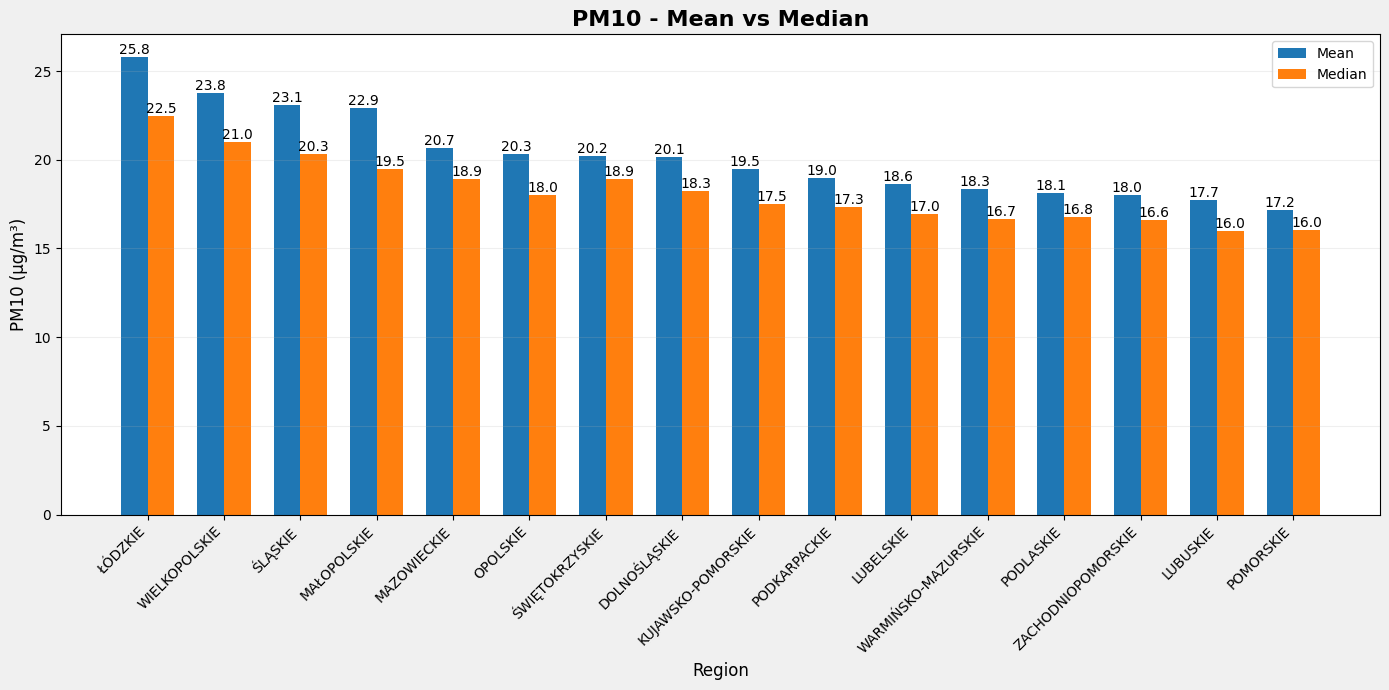

In [38]:
# PM10 level for every region (mean and median)
pm10_cols = [col for col in all_data.columns if col.startswith('PM10_')]

stats = all_data[pm10_cols].describe().T
stats.columns = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
stats.index = [idx.replace('PM10_', '') for idx in stats.index]
stats = stats.sort_values('mean', ascending=False)

fig, ax = plt.subplots(figsize=(14, 7), facecolor='#f0f0f0')

x = np.arange(len(stats))
width = 0.35

ax.bar(x - width/2, stats['mean'], width, label='Mean')
ax.bar(x + width/2, stats['50%'], width, label='Median')

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f')

ax.set_xlabel('Region', fontsize=12)
ax.set_ylabel('PM10 (µg/m³)', fontsize=12)
ax.set_title('PM10 - Mean vs Median', fontsize=16, weight='bold')

ax.set_xticks(x)
ax.set_xticklabels(stats.index, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.2, axis='y')

plt.tight_layout()
plt.savefig('../images/pm10_mean_vs_median.png')
plt.show()

C:\Users\Przemek\AppData\Local\Temp\ipykernel_7612\3477600002.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i].legend(fontsize=8)


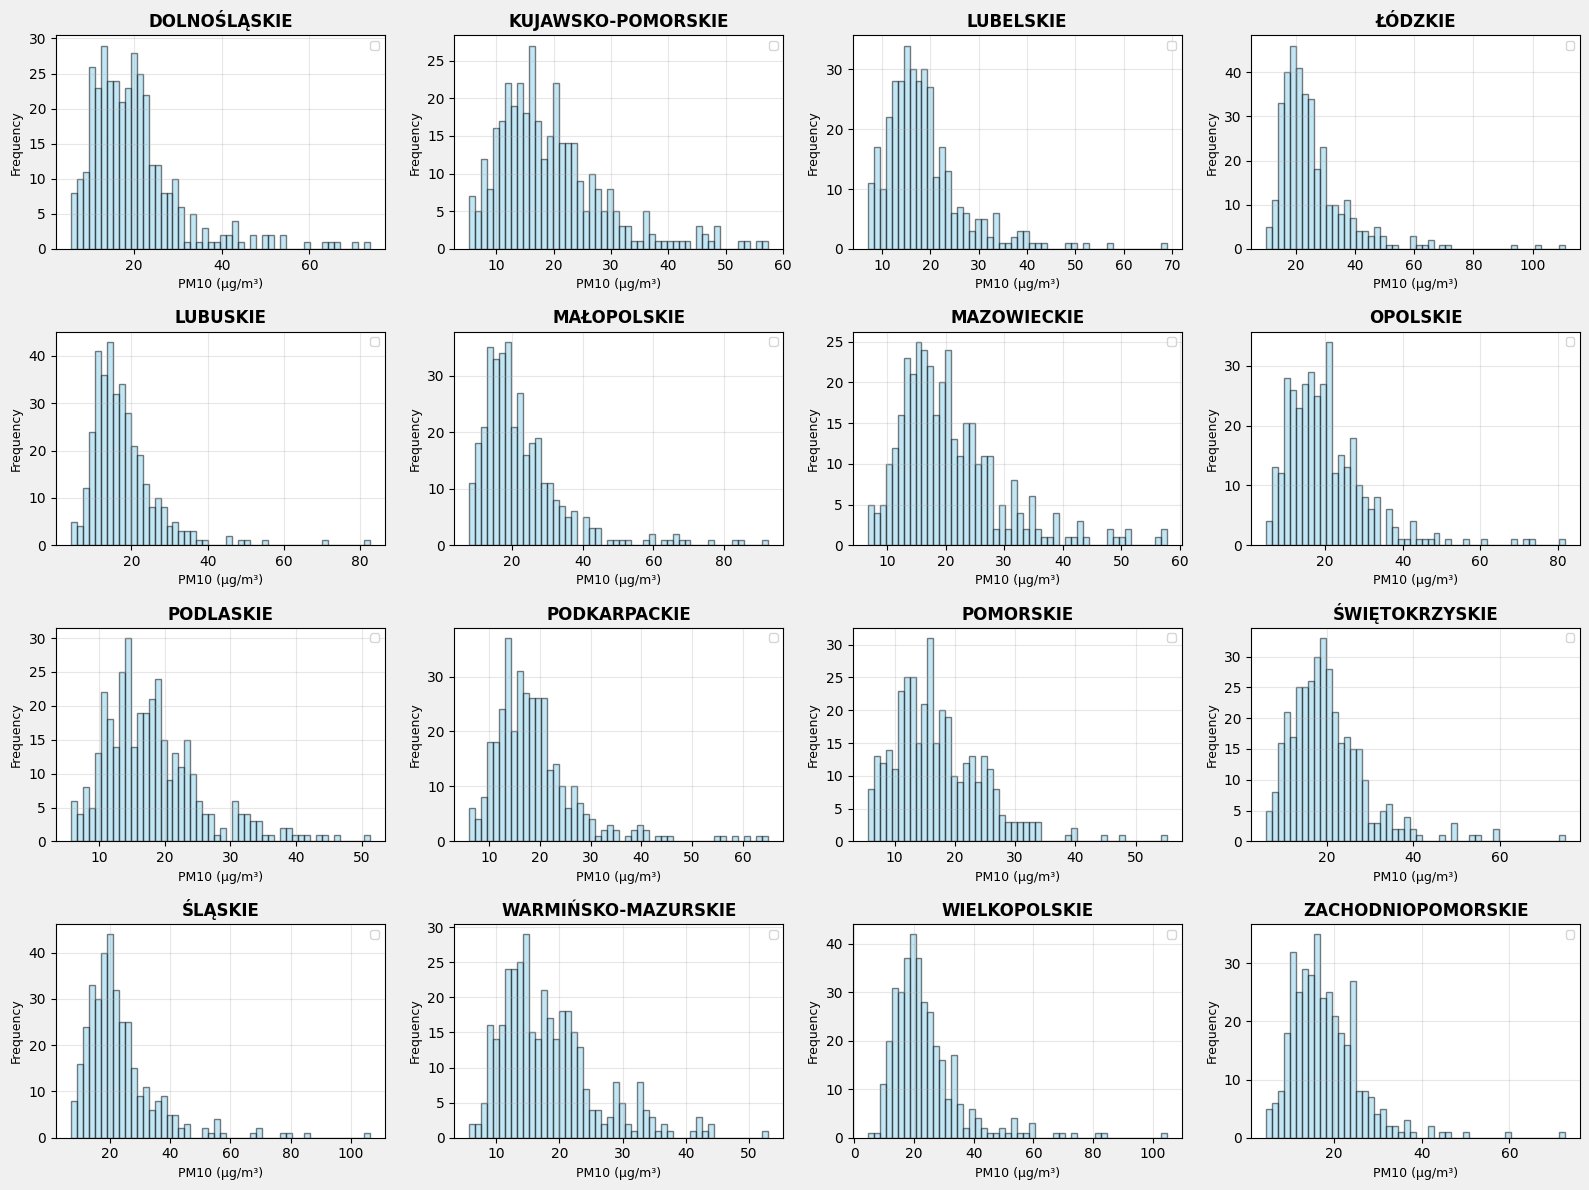

In [39]:
# Histograms for every region
regions = [col.replace('PM10_', '') for col in pm10_cols]

fig, ax = plt.subplots(4, 4, figsize=(16, 12), facecolor='#f0f0f0')
ax = ax.flatten()

for i, (col, reg) in enumerate(zip(pm10_cols, regions)):
    if i < len(ax):
        data = all_data[col].dropna()

        ax[i].hist(data, bins=50, edgecolor='black', alpha=0.5, color='skyblue')

        ax[i].set_title(reg, fontsize=12, weight='bold')
        ax[i].set_xlabel('PM10 (µg/m³)', fontsize=9)
        ax[i].set_ylabel('Frequency', fontsize=9)
        ax[i].legend(fontsize=8)
        ax[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../images/voivodeships_histograms')
plt.show()

C:\Users\Przemek\AppData\Local\Temp\ipykernel_7612\3815281871.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplots = plt.boxplot([pm10_data[col].dropna() for col in pm10_data.columns],


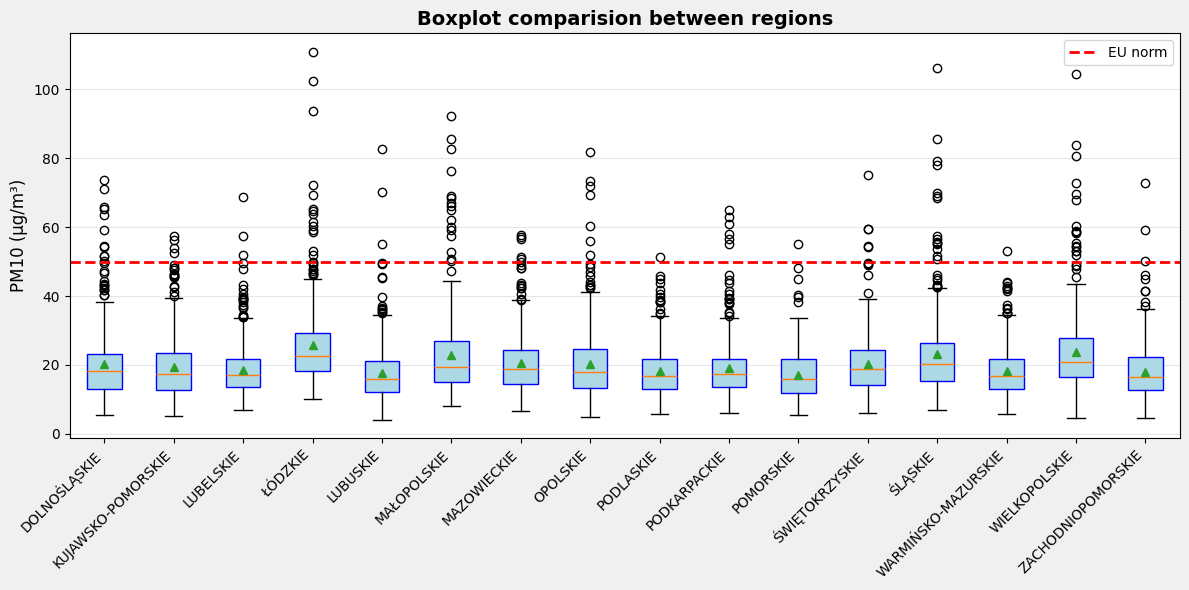

In [40]:
# Boxplots comparision
pm10_data = all_data[pm10_cols].copy()
pm10_data.columns = [col.replace('PM10_', '') for col in pm10_data.columns]

means = pm10_data.mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6), facecolor='#f0f0f0')
boxplots = plt.boxplot([pm10_data[col].dropna() for col in pm10_data.columns],
                       labels=pm10_data.columns,
                       showmeans=True,
                       patch_artist=True,
                       boxprops=dict(facecolor='lightblue', color='blue'))

colors = ['lightcoral' if means[col] > 50 else 'lightblue' for col in pm10_data.columns]

# Average value determined globally
plt.axhline(50, color='red', linestyle='--', linewidth=2, label='EU norm')
plt.ylabel('PM10 (µg/m³)', fontsize=12)
plt.title('Boxplot comparision between regions', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

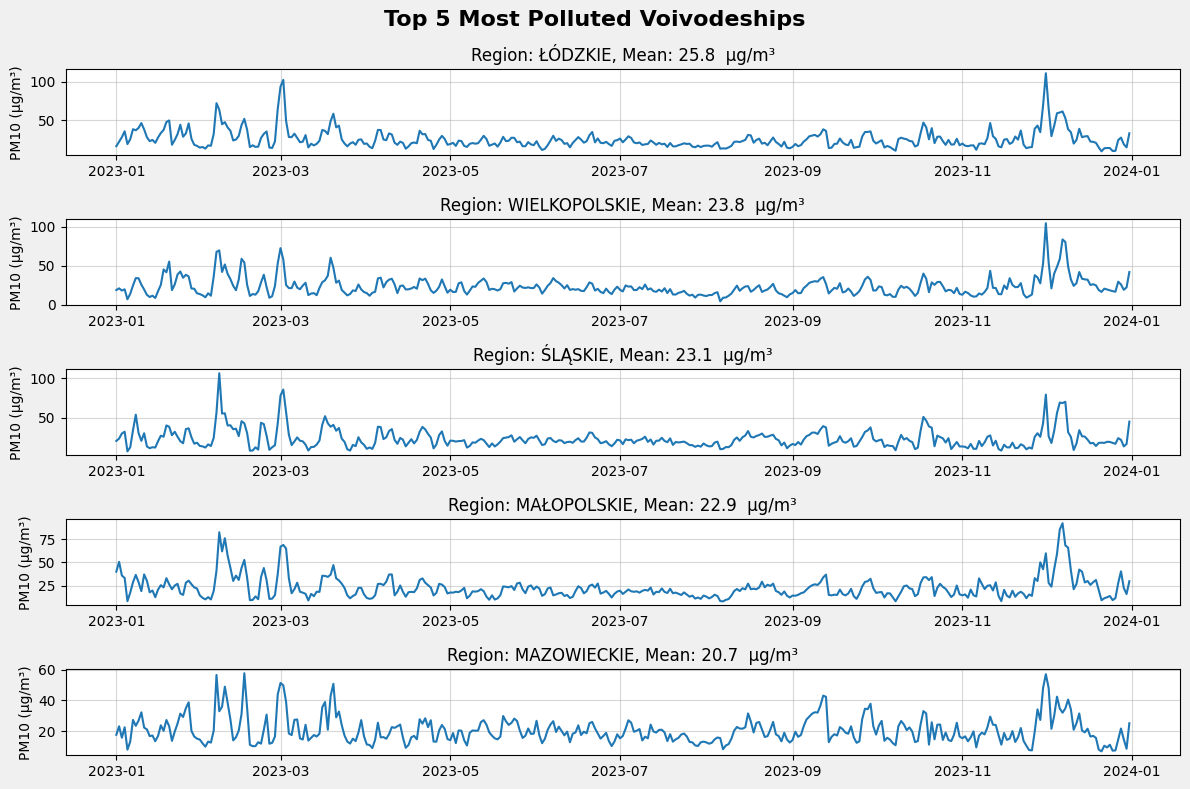

In [41]:
# Top 5 most polluted regions

means2= all_data[pm10_cols].mean().sort_values(ascending=False)
top_voivodeship = means2.head(5).index

fig, ax = plt.subplots(5, 1, figsize=(12 ,8), facecolor='#f0f0f0')

for i, col in enumerate(top_voivodeship):
        voiv = col.replace('PM10_', '')

        ax[i].plot(all_data.index, all_data[col])

        ax[i].set_ylabel('PM10 (µg/m³)')
        ax[i].set_title(f'Region: {voiv}, Mean: {means2[col]:.1f}  µg/m³')
        ax[i].grid(True, alpha=0.5)

plt.suptitle('Top 5 Most Polluted Voivodeships', weight='bold', fontsize=16)

plt.tight_layout()
plt.savefig('../images/top5_most_polluted_regions.png')
plt.show

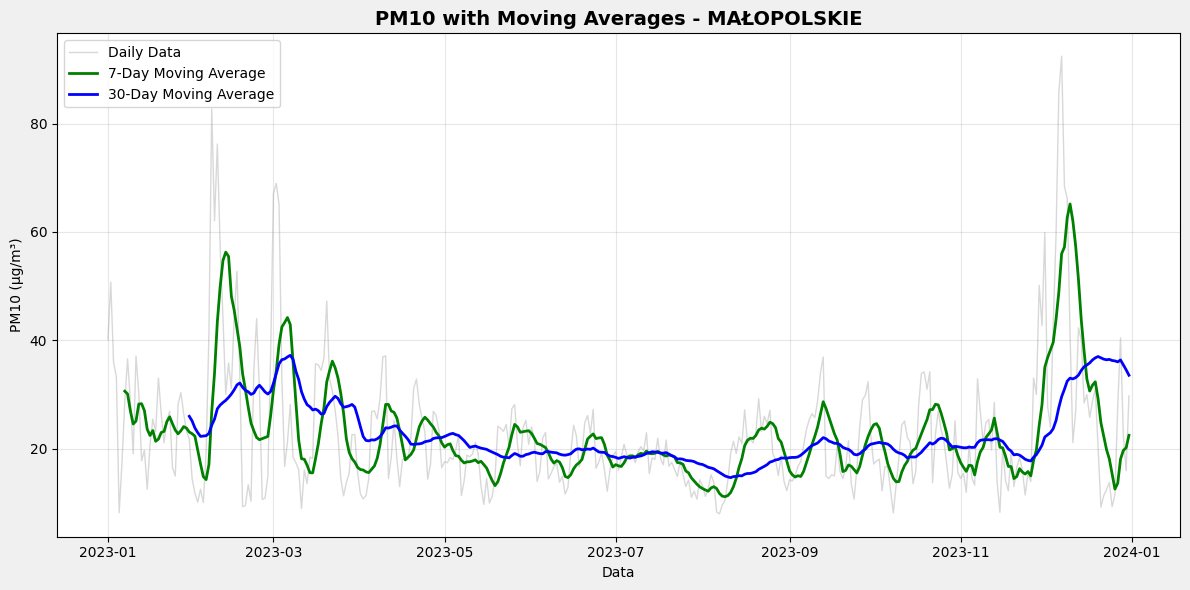

In [42]:
# Moving Averages for Lesser Poland

voivodeship = 'MAŁOPOLSKIE'
col = f'PM10_{voivodeship}'
windows=[7, 30]

plt.figure(figsize=(12, 6), facecolor='#f0f0f0')
plt.plot(all_data.index, all_data[col], color='grey', label='Daily Data', linewidth=1, alpha=0.3)

colors = ['green', 'blue']
for i, window in enumerate(windows):
    MA = all_data[col].rolling(window=window).mean()
    plt.plot(all_data.index, MA, label=f'{window}-Day Moving Average', linewidth=2, color=colors[i])

plt.title(f'PM10 with Moving Averages - {voivodeship}', fontsize=14, fontweight='bold')
plt.xlabel('Data')
plt.ylabel('PM10 (µg/m³)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../images/moving_averages.png')
plt.show()

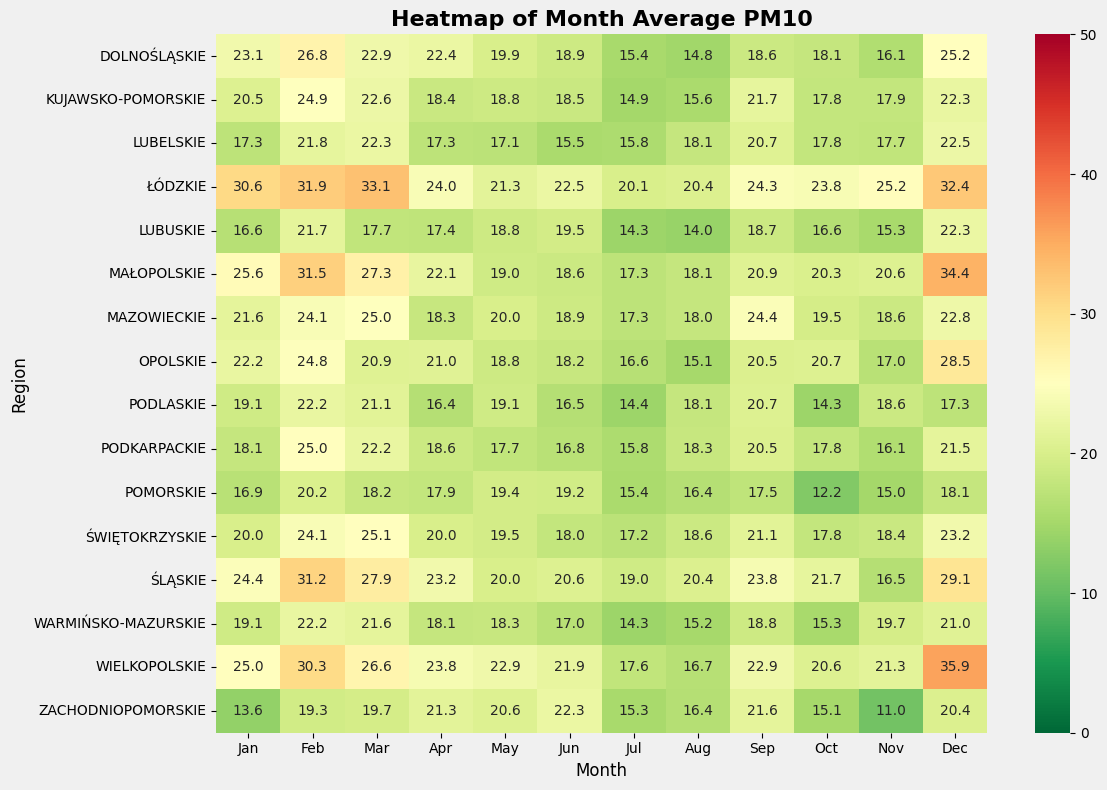

In [43]:
# Monthly heatmap for all regions

copied_data = all_data.copy()
copied_data['month'] = copied_data.index.month

monthly_means = copied_data.groupby('month')[pm10_cols].mean()
monthly_means.columns = [col.replace('PM10_', '') for col in monthly_means.columns]

plt.figure(figsize=(12, 8), facecolor='#f0f0f0')
sns.heatmap(monthly_means.T, annot=True, fmt='.1f', cmap='RdYlGn_r', vmin=0, vmax=50)

plt.title('Heatmap of Month Average PM10', fontsize=16, weight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.xticks(np.arange(12) + 0.5, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.tight_layout()
plt.savefig('../images/heatmap_for_months.png')
plt.show()

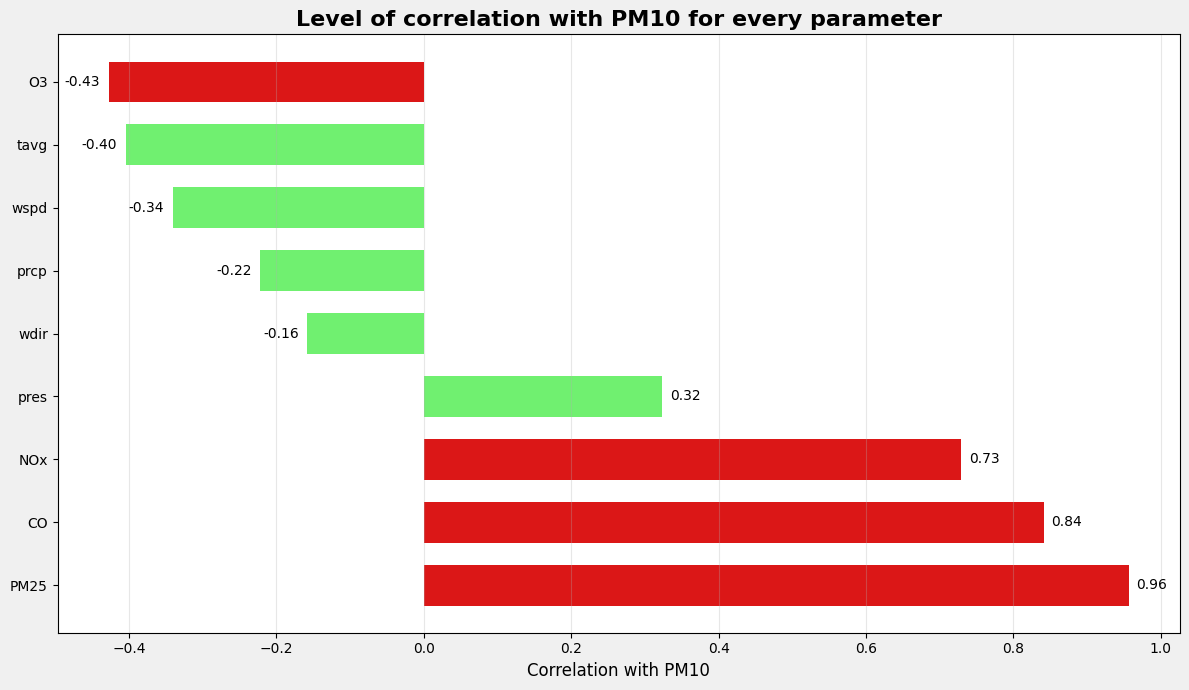

In [44]:
# Correlation ranking PM10 with other parameters

voivodeship = 'MAŁOPOLSKIE'
pm10_col = f'PM10_{voivodeship}'
    
cols = [col for col in all_data.columns if voivodeship in col and col != pm10_col]
    
# Oblicz korelacje z PM10
correlations = all_data[cols].corrwith(all_data[pm10_col]).sort_values(ascending=False)
correlations = correlations.head(10)

paramater_names = [col.split('_')[0] for col in correlations.index]
pollutants = ['PM25', 'CO', 'NOx', 'O3']
colors = ["#DB1717" if param_name in pollutants else "#70F070" for param_name in paramater_names]

plt.figure(figsize=(12, 7), facecolor='#f0f0f0')
plt.barh(range(len(correlations)), correlations.values, color=colors, height=0.65)
plt.yticks(range(len(correlations)), paramater_names)

for i, v in enumerate(correlations.values):
    if v > 0:
        plt.text(v + 0.01, i, f"{v:.2f}", va='center')
    else:
        plt.text(v - 0.06, i, f"{v:.2f}", va='center')

plt.title('Level of correlation with PM10 for every parameter', fontsize=16, fontweight='bold')
plt.xlabel('Correlation with PM10', fontsize=12)

plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('../images/level_of_correlation.png')
plt.show()

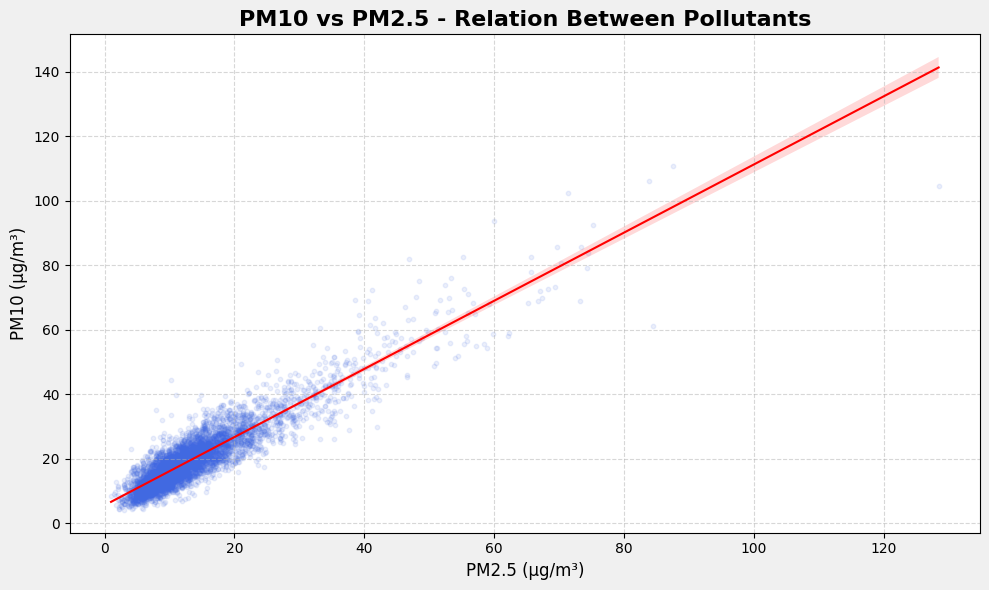

In [45]:
pm25_cols = [col for col in all_data.columns if col.startswith('PM25_')]

pm10_sorted = pm10_cols.sort()
pm25_sorted = pm25_cols.sort()

plt.figure(figsize=(10, 6), facecolor='#f0f0f0')

x_values = all_data[pm25_cols].values.flatten()
y_values = all_data[pm10_cols].values.flatten()

sns.regplot(
    x=x_values, 
    y=y_values,
    scatter_kws={'alpha': 0.1, 's': 10, 'color': 'royalblue'},
    line_kws={'color': 'red', 'linewidth': 1.5}
)

plt.title('PM10 vs PM2.5 - Relation Between Pollutants', fontsize=16, weight='bold')
plt.xlabel('PM2.5 (µg/m³)', fontsize=12)
plt.ylabel('PM10 (µg/m³)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('../images/pm10_vs_pm25.png')
plt.show()

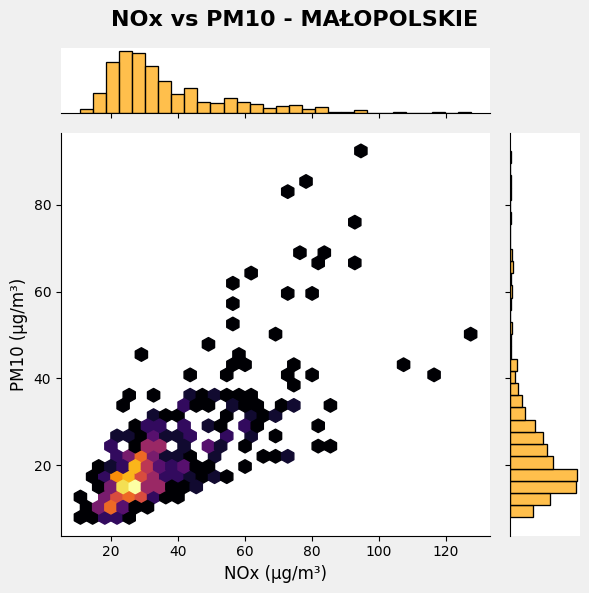

In [46]:
nox_col = f'NOx_{voivodeship}'

df = all_data[[nox_col, pm10_col]].dropna()

g = sns.jointplot(
        data=df,
        x=nox_col,
        y=pm10_col,
        kind='hex',              
        height=6,               
        cmap='inferno',         
        marginal_kws={
            'color': 'orange',
            'bins': 30,
            'alpha': 0.7
        },
        joint_kws={
            'gridsize': 32,      
            'mincnt': 1          
        }
    )

g.set_axis_labels('NOx (µg/m³)', 'PM10 (µg/m³)', fontsize=12)
g.fig.suptitle(f'NOx vs PM10 - {voivodeship}', fontsize=16, weight='bold')
g.fig.patch.set_facecolor('#f0f0f0')

plt.tight_layout()
plt.show()

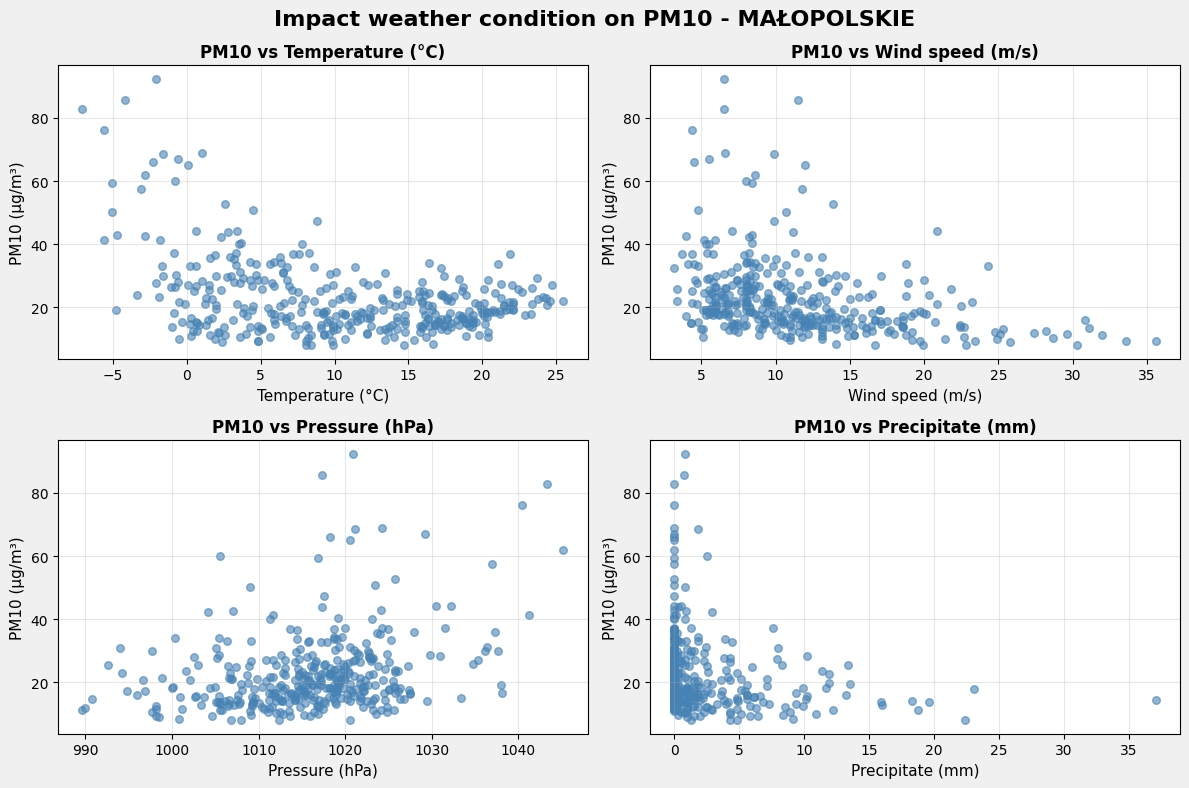

In [47]:
weather_index = ['tavg', 'wspd', 'pres', 'prcp']
weather_labels = {
    'tavg': 'Temperature (°C)',
    'wspd': 'Wind speed (m/s)',
    'pres': 'Pressure (hPa)',
    'prcp': 'Precipitate (mm)'
}

fig, ax = plt.subplots(2, 2, figsize=(12, 8), facecolor='#f0f0f0')
ax = ax.flatten()

for i, idx in enumerate(weather_index):
    tag = f'{idx}_{voivodeship}'

    if tag in all_data.columns:
        ax[i].scatter(all_data[tag], all_data[pm10_col], color='steelblue', s=30, alpha=0.6)

        ax[i].set_xlabel(weather_labels[idx], fontsize=11)
        ax[i].set_ylabel('PM10 (µg/m³)', fontsize=11)
        ax[i].set_title(f'PM10 vs {weather_labels[idx]}', fontweight='bold')
        ax[i].grid(True, alpha=0.3)
    
plt.suptitle(f'Impact weather condition on PM10 - {voivodeship}', 
            fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../images/impact_weather_condition_on_pm10.png')
plt.show()

C:\Users\Przemek\AppData\Local\Temp\ipykernel_7612\1763614844.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  interaction = interaction_df.groupby(['temp_cat', 'wspd_cat'])[pm10_col].mean().unstack()


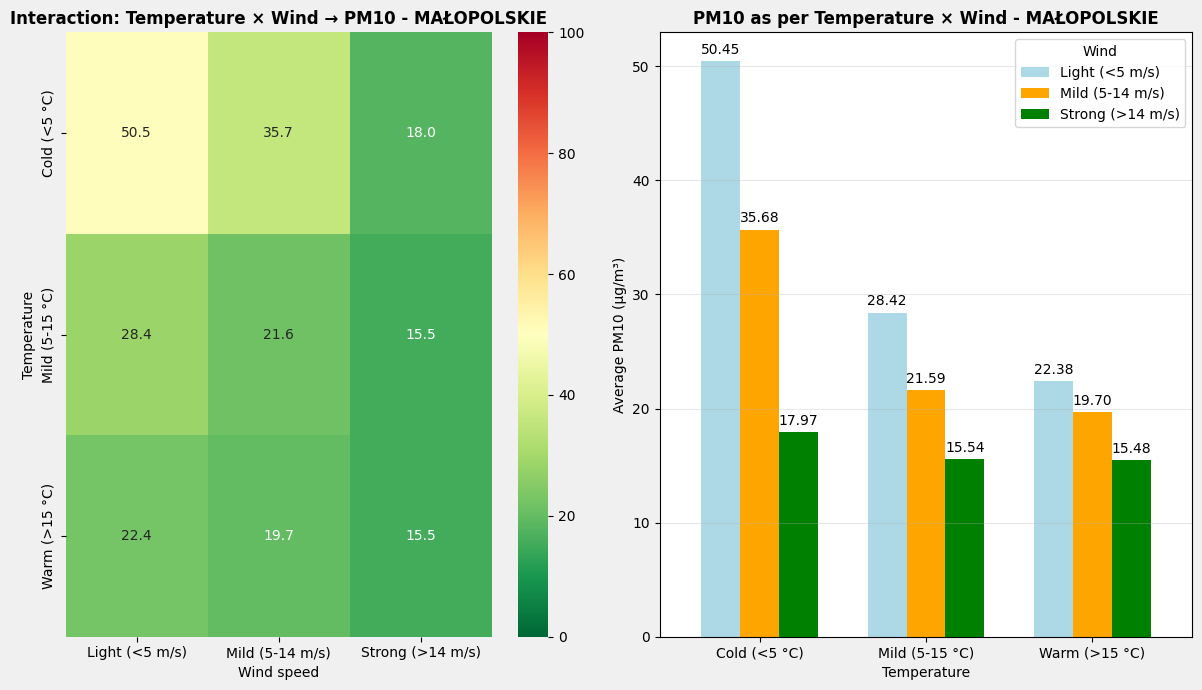

In [48]:
# Temperature vs wind speed interaction

tavg_col = f'tavg_{voivodeship}'
wspd_col = f'wspd_{voivodeship}'

interaction_df = all_data[[pm10_col, tavg_col, wspd_col]].dropna()

interaction_df['temp_cat'] = pd.cut(interaction_df[tavg_col], bins=[-np.inf, 5, 15, np.inf],
                                    labels=['Cold (<5 °C)', 'Mild (5-15 °C)', 'Warm (>15 °C)'])

interaction_df['wspd_cat'] = pd.cut(interaction_df[wspd_col], bins=[0, 5, 14, np.inf],
                                    labels=['Light (<5 m/s)', 'Mild (5-14 m/s)', 'Strong (>14 m/s)'])

interaction = interaction_df.groupby(['temp_cat', 'wspd_cat'])[pm10_col].mean().unstack()

fig, ax = plt.subplots(1, 2, figsize=(12, 7), facecolor='#f0f0f0')
sns.heatmap(interaction, annot=True, cmap='RdYlGn_r', fmt='.1f', ax=ax[0], vmin=0, vmax=100)
ax[0].set_title(f'Interaction: Temperature × Wind → PM10 - {voivodeship}', fontsize=12, fontweight='bold')
ax[0].set_xlabel('Wind speed')
ax[0].set_ylabel('Temperature')

interaction.plot(kind='bar', ax=ax[1], color=['lightblue', 'orange', 'green'], width=0.7)
for container in ax[1].containers:
    ax[1].bar_label(container, fmt='%.2f', padding=3)
ax[1].set_title(f'PM10 as per Temperature × Wind - {voivodeship}', fontsize=12, fontweight='bold')
ax[1].set_ylabel('Average PM10 (µg/m³)')
ax[1].set_xlabel('Temperature')
ax[1].legend(title='Wind')
ax[1].grid(True, alpha=0.3, axis='y')
ax[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('../images/wind_vs_teamperature_barplot_and_heatmap.png')
plt.show()

C:\Users\Przemek\AppData\Local\Temp\ipykernel_7612\3059493797.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  winter_pres = winter_data.groupby('pres_cat')[pm10_col].mean()
C:\Users\Przemek\AppData\Local\Temp\ipykernel_7612\3059493797.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summer_pres = summer_data.groupby('pres_cat')[pm10_col].mean()


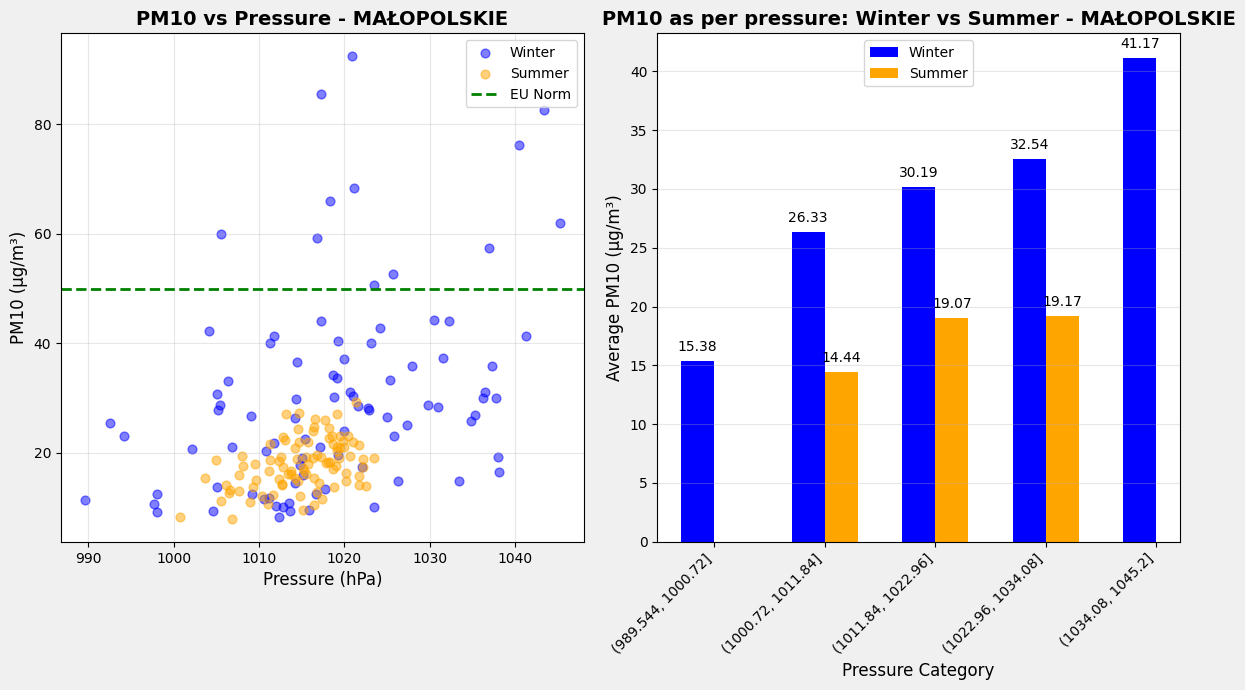

In [49]:
pres_col = f'pres_{voivodeship}'

calc_pres = all_data[[pm10_col, pres_col]].copy()
calc_pres['month'] = calc_pres.index.month
calc_pres['season'] = calc_pres['month'].map({
    1: 'Winter', 2: 'Winter', 12: 'Winter',
    6: 'Summer', 7: 'Summer', 8: 'Summer'
})
calc_pres = calc_pres[calc_pres['season'].notna()]

fig, ax = plt.subplots(1, 2, figsize=(12, 7), facecolor='#f0f0f0')

for season, color in [('Winter', 'blue'), ('Summer', 'orange')]:
    season_data = calc_pres[calc_pres['season'] == season]
    ax[0].scatter(season_data[pres_col], season_data[pm10_col], s=40, alpha=0.5, color=color, label=season)

ax[0].axhline(50, color='green', linestyle='--', linewidth=2, label='EU Norm')
ax[0].set_xlabel('Pressure (hPa)', fontsize=12)
ax[0].set_ylabel('PM10 (µg/m³)', fontsize=12)
ax[0].set_title(f'PM10 vs Pressure - {voivodeship}', fontsize=14, fontweight='bold')
ax[0].legend()
ax[0].grid(True, alpha=0.3)

calc_pres['pres_cat'] = pd.cut(calc_pres[pres_col], bins=5)

winter_data = calc_pres[calc_pres['season'] == 'Winter']
summer_data = calc_pres[calc_pres['season'] == 'Summer']

winter_pres = winter_data.groupby('pres_cat')[pm10_col].mean()
summer_pres = summer_data.groupby('pres_cat')[pm10_col].mean()

x = np.arange(len(winter_pres))
width = 0.3

ax[1].bar(x - width/2, winter_pres.values, width, label='Winter', color='blue')
ax[1].bar(x + width/2, summer_pres.values, width, label='Summer', color='orange')

for container in ax[1].containers:
    ax[1].bar_label(container, fmt='%.2f', padding=5)

ax[1].set_xlabel('Pressure Category', fontsize=12)
ax[1].set_ylabel('Average PM10 (µg/m³)', fontsize=12)
ax[1].set_title(f'PM10 as per pressure: Winter vs Summer - {voivodeship}', fontsize=14, fontweight='bold')
ax[1].set_xticks(x)
ax[1].set_xticklabels([f'{cat}' for cat in winter_pres.index], rotation=45, ha='right')
ax[1].legend()
ax[1].grid(True, alpha=0.3, axis='y')
    
plt.tight_layout()
plt.show()

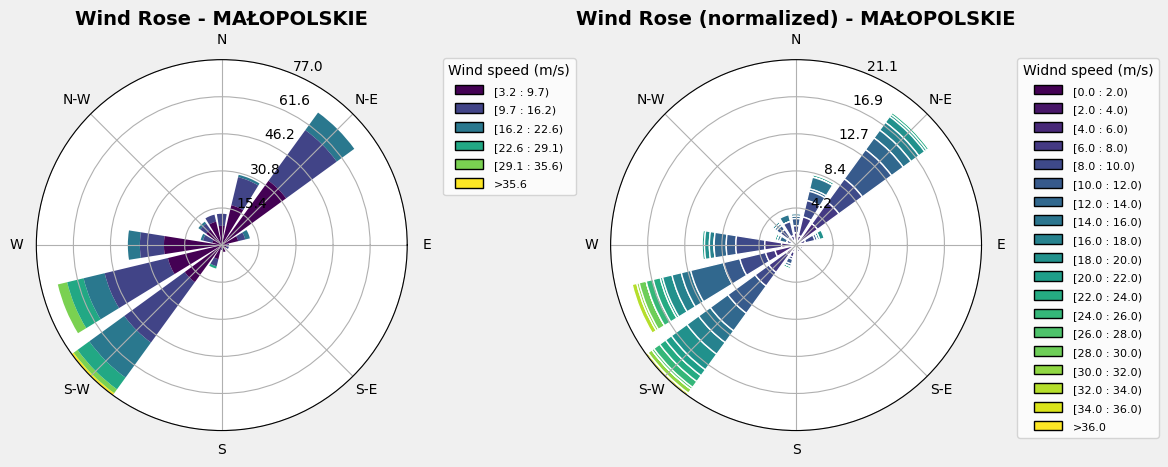

In [50]:
# Pollution Rose

wdir_col = f'wdir_{voivodeship}'
wind_data = all_data[[pm10_col, wdir_col, wspd_col]].dropna()

fig = plt.figure(figsize=(12, 9), facecolor='#f0f0f0')

ax0 = fig.add_subplot(2, 2, 1, projection='windrose')
ax0.bar(wind_data[wdir_col], wind_data[wspd_col])
ax0.set_title(f'Wind Rose - {voivodeship}', fontsize=14, fontweight='bold')
ax0.set_legend(title='Wind speed (m/s)', loc='upper left', bbox_to_anchor=(1.1, 1))

ax1 = fig.add_subplot(2, 2, 2, projection='windrose')
ax1.bar(wind_data[wdir_col], wind_data[wspd_col], bins=np.arange(0, wind_data[wspd_col].max() + 2, 2),
            normed=True, opening=0.8, edgecolor='white')
ax1.set_title(f'Wind Rose (normalized) - {voivodeship}', fontsize=14, fontweight='bold')
ax1.set_legend(title='Widnd speed (m/s)', loc='upper left', bbox_to_anchor=(1.1, 1))

plt.tight_layout()
plt.savefig('../images/wind_rose.png')
plt.show()

## Feature Engineering

In [51]:
# Reshaping dataframe to more convinient format
all_data.index.name = 'Time'
parameters = ['PM10', 'PM25', 'wspd', 'NOx', 'CO', 'O3', 'tavg', 'pres', 'wdir', 'prcp']
melted_data = []

to_melt = all_data.reset_index() if 'Time' not in all_data.columns else all_data.copy()

for param in parameters:
    col = [c for c in to_melt.columns if c.startswith(f'{param}_')]

    data_features = to_melt.melt(
        id_vars=['Time'],
        value_vars=col,
        var_name='State',
        value_name=param
    )

    data_features['State'] = data_features['State'].str.split('_').str[1]
    data_features = data_features.set_index(['Time', 'State'])
    melted_data.append(data_features)

data_final = pd.concat(melted_data, axis=1).reset_index()
data_final.head()

,Time,State,PM10,PM25,wspd,NOx,CO,O3,tavg,pres,wdir,prcp
0,2023-01-01,DOLNOŚLĄSKIE,21.407143,13.20,18.6,12.795030,0.343800,48.661895,14.8,1019.2,228.0,0.0
1,2023-01-02,DOLNOŚLĄSKIE,26.992857,13.28,12.8,24.287492,0.428124,40.153922,11.4,1019.4,196.0,0.0
2,2023-01-03,DOLNOŚLĄSKIE,26.064286,16.58,10.1,37.883956,0.504437,48.959374,6.9,1027.6,282.0,0.0
3,2023-01-04,DOLNOŚLĄSKIE,18.685714,13.24,17.9,28.080206,0.471780,43.973321,4.7,1021.6,204.0,1.9
4,2023-01-05,DOLNOŚLĄSKIE,7.067857,4.98,26.1,11.060846,0.321745,59.941038,9.1,1012.1,289.0,4.3


In [52]:
data_feature = data_final.copy()

X_cluster = means.values.reshape(-1, 1)
    
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_cluster)

cluster_names = []
for i in range(3):
    cluster_names.append(means[clusters == i].mean())

cluster_labels = ['low', 'medium', 'high']
sorted_regions = np.argsort(cluster_names)
cluster_mapping = {i: cluster_labels[sorted_regions[i]] for i in range(3)}

state_cluster = dict(zip(means.index, clusters))
state_pm10_level = {state: cluster_mapping[cluster] for state, cluster in state_cluster.items()}

data_feature['region_cluster'] = data_feature['State'].map(state_pm10_level)
data_feature['region_cluster'] = data_feature['region_cluster'].astype('category')

Level of pollution in every region was added to help model recognise scale of pollution. Using KMeans algorithm clusters were applied automaticly by mean valur of the pollution in single voivodeship

In [53]:
data_feature['month'] = data_feature['Time'].dt.month

In [54]:
pollutants = ['PM10', 'PM25', 'NOx', 'CO', 'O3']

for pollutant in pollutants:
    data_feature[f'{pollutant}_lag1'] = data_feature.groupby('State')[pollutant].shift(1)
    data_feature[f'{pollutant}_lag2'] = data_feature.groupby('State')[pollutant].shift(2)

Creating lag for every pollunant to capture future trend. It helps catch the moment where smog is accumulating and increase predicting weather condition and quality.

In [55]:
windows = [7, 30]
pm10_new_col = 'PM10'

for window in windows:
    group = data_feature[pm10_new_col]

    roll_mean = group.transform(lambda x: x.shift(1).rolling(window=window).mean())
    roll_median = group.transform(lambda x: x.shift(1).rolling(window=window).median())
    
    data_feature[f'pm10_mean_median_ratio_{window}d'] = roll_mean / (roll_median + 0.0001)

data_feature['ratio_trend'] = data_feature['pm10_mean_median_ratio_30d'].shift(1).diff(1)

New created feature ratio trend will help the model to capture spike pollution in next days. Instead of predicting tomorrow bounce it is better to capture direction of future changes.

In [56]:
# Logarithm transformation
data_feature['pm10_log'] = np.log1p(data_feature['PM10'])

# Log transformation was also added to other important pollutants which are also right skewed
data_feature['pm25_log'] = np.log1p(data_feature['PM25'])
data_feature['nox_log'] = np.log1p(data_feature['NOx'])
data_feature['co_log'] = np.log1p(data_feature['CO'])

# Heating seasons
data_feature['heating_seasons'] = data_feature['Time'].dt.month.isin([11, 12, 1, 2, 3])

# sin/cos trasnformation to help the model better understand months
data_feature['month_sin'] = np.sin(2 * np.pi * data_feature['Time'].dt.month / 12)
data_feature['month_cos'] = np.cos(2 * np.pi * data_feature['Time'].dt.month / 12)

Logrithmic transformation was applied to overcome right skewness mainly for PM10 but also for other pollutatnt which are highly correlated with main pollutant such as NOx, CO and PM25. 

Heating season column will be able to help model with spikes of PM10 during whole year, as the charts showed that mostly winter months have tenency to have more fluctuations and high amount of PM10.

sin/cos transformation was added to help the model better understand month cycle, e.g 1 and 12 are far away but they are really close simoultaniously. This tranfosmation will help to cpture this.

In [57]:
data_feature['is_weekend'] = data_feature['Time'].dt.day_of_week.isin([5,6]).astype(int)

data_feature['day_of_week'] = data_feature['Time'].dt.day_of_week

data_feature['day_sin'] = np.sin(2 * np.pi * data_feature['day_of_week'] / 7)
data_feature['day_cos'] = np.cos(2 * np.pi * data_feature['day_of_week'] / 7)

Also is_weekend column was added to capture different level of pollution in weekends and also day_sin/cos which help for example linear regression find neighbouring day of weeks.

In [58]:
data_feature['co_nox_ratio'] = data_feature['CO'] / (data_feature['NOx'] + 0.0001)

data_feature['PM25_NOx_ratio'] = data_feature['PM25'] / (data_feature['NOx'] + 0.0001)

Ratio CO/NOx: if this ratio increases, model will know that it dominates furnace what is crucial for frozen days

Ratio NOx/wspd: NOx + lack of wind means increased PM10. It connects strong correlated pollutant with wind speed where mean PM10 value increases where wind speed is lower.

In [59]:
data_feature['stagnation_ratio'] = 1 / ((data_feature['wspd'] + 0.05) * data_feature['tavg'] + 10)

data_feature['is_smog_window'] = ((data_feature['tavg'] < 5) & (data_feature['wspd'] < 5)).astype(int)

The chart with temperature and wind showed high dependence where wind speed is light (< 5 m/s) and temaperature is low (< 5 celcius degress). Future model will see that this condition is highly polluted with PM10. New features will mirror nonlinear increase with lack of circulation and low temperature level and also they will classify days with high risk of exceeded PM10 norm.

Scatter plot showed that low temperature and light wind have high PM10 value.

In [60]:
data_feature['high_pres_winter'] = ((data_feature['heating_seasons'] == 1) & (data_feature['pres'] > 1020)).astype(int)

data_feature['pres_diff'] = data_feature.groupby('State')['pres'].diff()

Binary clue (high_pres_winter) was created to help the model capture high risk PM10 parameter. Most PM10 polluted values come from winter where air pressure increases.

pres_diff help to capture that increasing pressure value may spell high PM10 value.

In [61]:
data_feature['wind_sin'] = data_feature['wspd'] * np.sin(2 * np.pi * data_feature['wdir'] / 360)
data_feature['wind_cos'] = data_feature['wspd'] * np.cos(2 * np.pi * data_feature['wdir'] / 360)

data_feature['wind_range'] = data_feature['wdir'].apply(
    lambda x: 1 if (22.5 <= x <= 67.5) or (202.5 <= x <= 247.5) else 0
)

By wind_sin and wind_cos components circular data problem is solved, values 1* and 359* are quite close to each other. 

Also I noticed that most wind direction come from south-west and north-east, so properly range was applied.

In [62]:
data_feature['pm10_log_lag1'] = np.log1p(data_feature['PM10_lag1'])
data_feature['pm10_log_lag2'] = np.log1p(data_feature['PM10_lag2'])

In [63]:
data_feature = data_feature.dropna()

In [64]:
train_list = []
test_list = []

# Iteration over regions allows to take 70% each of the single region
for state, group in data_feature.groupby('State'):
    group = group.sort_values('Time')

    split_idx = int(len(group) * 0.7)
    train_group = group.iloc[:split_idx]
    test_group = group.iloc[split_idx:]

    train_list.append(train_group)
    test_list.append(test_group)

data_train = pd.concat(train_list)
data_test = pd.concat(test_list)

In [65]:
X_train = data_train.drop(columns=['PM10', 'pm10_log', 'Time'])
y_train = data_train['pm10_log']

X_test = data_test.drop(columns=['PM10', 'pm10_log', 'Time'])
y_test = data_test['pm10_log']

In [66]:
# Applying RobustScaler because of endurance to outliers and great preparation before building models
scaler = RobustScaler()

numeric_cols = ['PM25', 'wspd', 'NOx', 'CO', 'O3', 'tavg', 'pres', 'wdir', 'prcp', 'PM10_lag1', 'PM10_lag2',
       'PM25_lag1', 'PM25_lag2', 'NOx_lag1', 'NOx_lag2', 'CO_lag1', 'CO_lag2', 'O3_lag1', 'O3_lag2', 
       'pm10_mean_median_ratio_7d', 'pm10_mean_median_ratio_30d', 'ratio_trend', 'pm25_log', 'nox_log', 
       'co_log', 'co_nox_ratio', 'PM25_NOx_ratio', 'pres_diff','wind_sin', 
       'wind_cos', 'wind_range']

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

## Models Building and Evaluating



### First Model - Support Vector Regression (SVR)

Support Vecotr Regression is perfect for catchinig non-linear relationships. It help mapping data to multi dimensional space to better capture some feautres. It is also endure to outliers which appear sometimes mostly durnig polish holidays such as chrismas and during some specific weather condition, especially during winter. By using Robust Sclaer, some new logarithmic parameters and data encoding SVR may give pretty good results.

In [67]:
def data_preparing(X_train_scaled, y_train, X_test_scaled, y_test, state):
    train_mask = X_train_scaled['State'] == state
    test_mask = X_test_scaled['State'] == state

    pca = PCA(n_components=0.90)
        
    X_train_state = X_train_scaled[train_mask].drop(columns=['State'])
    y_train_state = y_train[train_mask]

    X_test_state = X_test_scaled[test_mask].drop(columns=['State'])
    y_test_state = y_test[test_mask]

    categorical_cols = X_train_state.select_dtypes(include=['category', 'object']).columns.tolist()

    X_train_state = pd.get_dummies(X_train_state, columns=categorical_cols, drop_first=True)
    X_test_state = pd.get_dummies(X_test_state, columns=categorical_cols, drop_first=True)

    X_train_state = pca.fit_transform(X_train_state[numeric_cols])
    X_test_state = pca.transform(X_test_state[numeric_cols])

    plt.figure(figsize=(10, 6), facecolor='#f0f0f0')
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
    plt.axhline(y=0.95, linestyle='-', color='red', label='95% variance')
    plt.axhline(y=0.9, linestyle='-', color='green', label='90% variance')
    plt.title('Explained Variance Ratio Plot', weight='bold', fontsize=16)
    plt.xlabel('Number of Cummulated Components', fontsize=12)
    plt.ylabel('Cummulated Explained Variance', fontsize=12)
    plt.grid(True, alpha=0.5)
    plt.legend(loc='lower right', fontsize=12)
    plt.tight_layout()
    plt.savefig('../images/explained_variance_ratio.png')
    plt.show()

    return X_train_state, y_train_state, X_test_state, y_test_state

In [68]:
def train_grid(X_train, y_train, X_test, y_test):
    param_dist = {
        'kernel': ['rbf', 'poly'],
        'C': loguniform(1, 100),
        'gamma': loguniform(0.001, 1.0),
        'epsilon': uniform(0.01, 1.0)
    }

    svr = SVR()

    random_search = RandomizedSearchCV(
        estimator=svr,
        param_distributions=param_dist,
        n_iter=50,
        cv=5,
        scoring='neg_mean_squared_error',
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_

    y_pred_log = best_model.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test)
    y_pred = np.maximum(y_pred, 0)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1))) * 100
    
    return best_model, {
        'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAPE': mape
    }

In [69]:
def visualisations(model, X_test, y_test, state):
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test)
    y_pred = np.maximum(y_pred, 0)

    fig, ax = plt.subplots(2, 2, figsize=(15, 12), facecolor='#f0f0f0')

    ax1 = ax[0, 0]
    ax1.scatter(y_true, y_pred, alpha=0.7,s=30)
    ax1.set_xlabel('Actual PM10 (µg/m³)')
    ax1.set_ylabel('Predicted PM10 (µg/m³)')
    ax1.set_title(f'Actual vs Predicted - {state}', weight='bold')
    ax1.grid(True, alpha=0.5)

    ax2 = ax[0, 1]
    residuals = y_true - y_pred
    ax2.scatter(y_pred, residuals, alpha=0.7, s=30)
    ax2.set_xlabel('Predicted PM10 (µg/m³)')
    ax2.set_ylabel('Residuals (µg/m³)')
    ax2.set_title(f'Predicted vs Residuals - {state}', weight='bold')
    ax2.grid(True, alpha=0.5)

    ax3 = ax[1, 0]
    ax3.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
    ax3.axvline(x=0, color='r', linestyle='--')
    ax3.set_xlabel('Residuals (µg/m³)')
    ax3.set_ylabel('Frequency (µg/m³)')
    ax3.set_title(f'Distribution of Residuals - {state}', weight='bold')
    ax3.grid(True, alpha=0.5)

    ax4 = ax[1, 1]
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1))) * 100
    
    metrics_text = f"""
    SVR PERFORMANCE METRICS
    {'='*40}
    
    R² Score:         {r2:.4f}
    RMSE:             {rmse:.2f} µg/m³
    MAE:              {mae:.2f} µg/m³
    MAPE:             {mape:.2f}%
    
    Model Info:
    Kernel:           {model.kernel}
    C:                {model.C}
    Gamma:            {model.gamma}
    Epsilon:          {model.epsilon}
    Support Vectors:  {len(model.support_)}
    
    Mean Actual:      {y_true.mean():.2f} µg/m³
    Mean Predicted:   {y_pred.mean():.2f} µg/m³
    """
    ax4.text(0.1, 0.5, metrics_text, fontsize=14, verticalalignment='center', family='monospace')

    plt.tight_layout()
    plt.savefig('../images/svr_visualisations.png')
    plt.show()

In [70]:
def run_svr_mechanism(X_train_scaled, y_train, X_test_scaled, y_test, state):
    X_train_svr, y_train_svr, X_test_svr, y_test_svr = data_preparing(
        X_train_scaled, y_train, X_test_scaled, y_test, state
    )

    model_svr, model_metrics = train_grid(
        X_train_svr, y_train_svr, X_test_svr, y_test_svr
    )

    visualisations(model_svr, X_test_svr, y_test_svr, state)

    return {
        'SVR_model': (model_svr, model_metrics),
    }

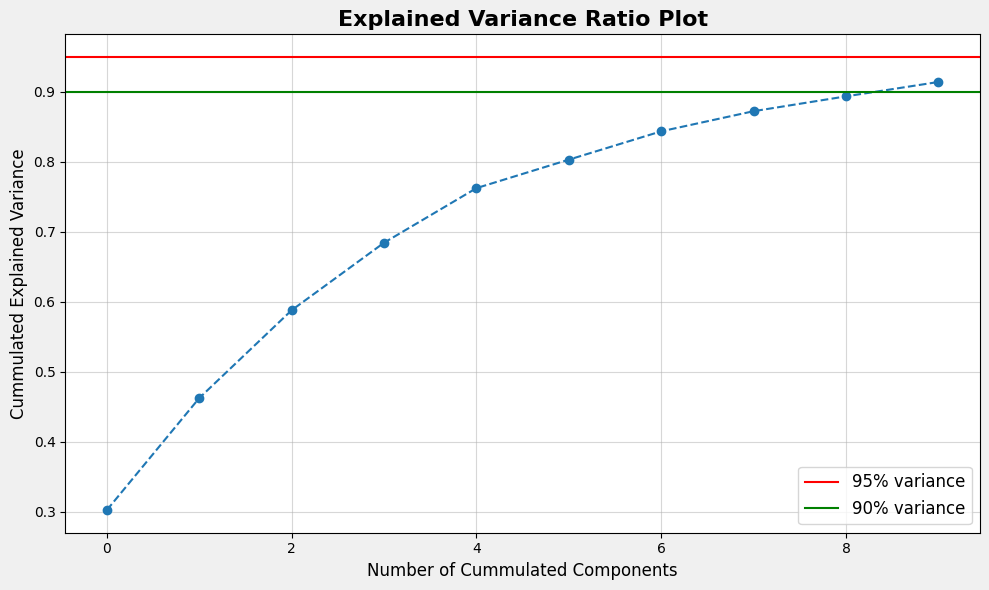

Fitting 5 folds for each of 50 candidates, totalling 250 fits


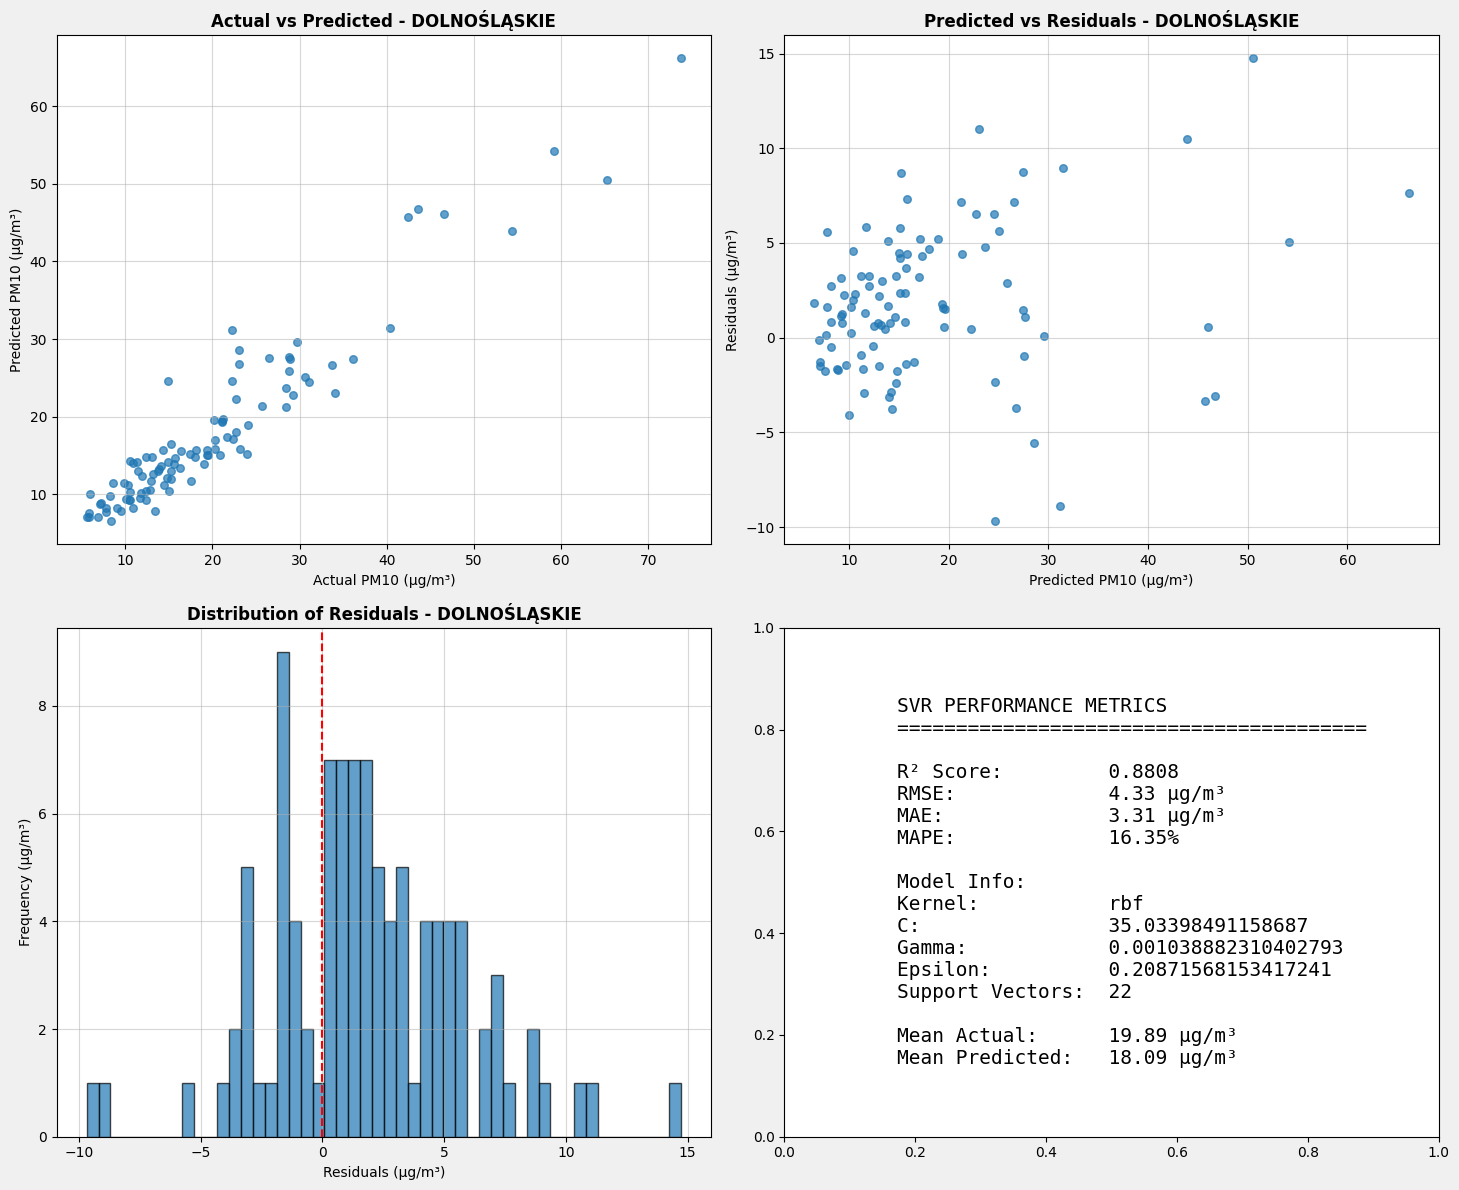

In [71]:
example_state = data_train['State'].unique()[0]

result = run_svr_mechanism(
    X_train_scaled, y_train, X_test_scaled, y_test, example_state
)

### Second Model - LightGBM

Trees models are perfect in choosing decisions as they are building rules based on decisions. Moreover. they are great for categorical boosting (catboost) as it has builded unique algorithm Ordered Boosting. Also LightGBM is using GOSS (Gradient-based One-Side Sampling) which focuse on data from which model learns more. From SVR it is hard to extract which columns is the most important, but trees-based models (boosting models) give us method to extract and visualise it. TO sum up they also do not need scailing which may be easy fo coder to imiplement.